In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['figure.dpi'] = 300

from tqdne.conf import Config
dataset_path = Config().datapath

In [3]:
import h5py

def load_waveforms_from_h5_dataset(file_path, n_samples=10):
    with h5py.File(file_path, 'r') as f:
        waveforms = f['waveforms'][:, :, :n_samples]
    return waveforms

waveforms = load_waveforms_from_h5_dataset(dataset_path)
waveforms.shape

(3, 5501, 10)

In [92]:
def envelope_first_order_lp(signal, k_env):
    envelope = np.zeros(len(signal))
    for i in range(1, len(signal)-1):
        if signal[i] > signal[i-1]:
            envelope[i] = signal[i]
        else:
            envelope[i] = k_env*envelope[i-1] + (1-k_env)*signal[i] # first order discrete time low pass filter
    return envelope

In [117]:
def plot_envelope(signal, title, envelope_function, **envelope_params):
    envelope = envelope_function(signal, **envelope_params)

    fig = plt.figure()
    
    ax1 = fig.add_subplot(211)
    ax1.plot(signal, alpha=0.6, label='signal')
    ax1.plot(envelope, linewidth=1,  label='envelope')
    ax1.set_title(title)
    ax1.legend()

    ax2 = fig.add_subplot(212)
    sig_scaledbyenvelope = np.nan_to_num(signal/envelope, nan=0., posinf=0., neginf=0.) # since if the envelope is 0, the signal is also small. 
    argmin_sig_env = np.argmin(sig_scaledbyenvelope)

    ax2.plot(sig_scaledbyenvelope)
    ax2.axvline(x=argmin_sig_env, color='r', linestyle='--')
    ax2.set_title("Signal scaled by its envelope")
    
    plt.tight_layout()
    plt.show()

    return envelope, sig_scaledbyenvelope, argmin_sig_env

/tmp/ipykernel_24663/1402080488.py:13: RuntimeWarning: divide by zero encountered in divide
  sig_scaledbyenvelope = np.nan_to_num(signal/envelope, nan=0., posinf=0., neginf=0.) # since if the envelope is 0, the signal is also small.


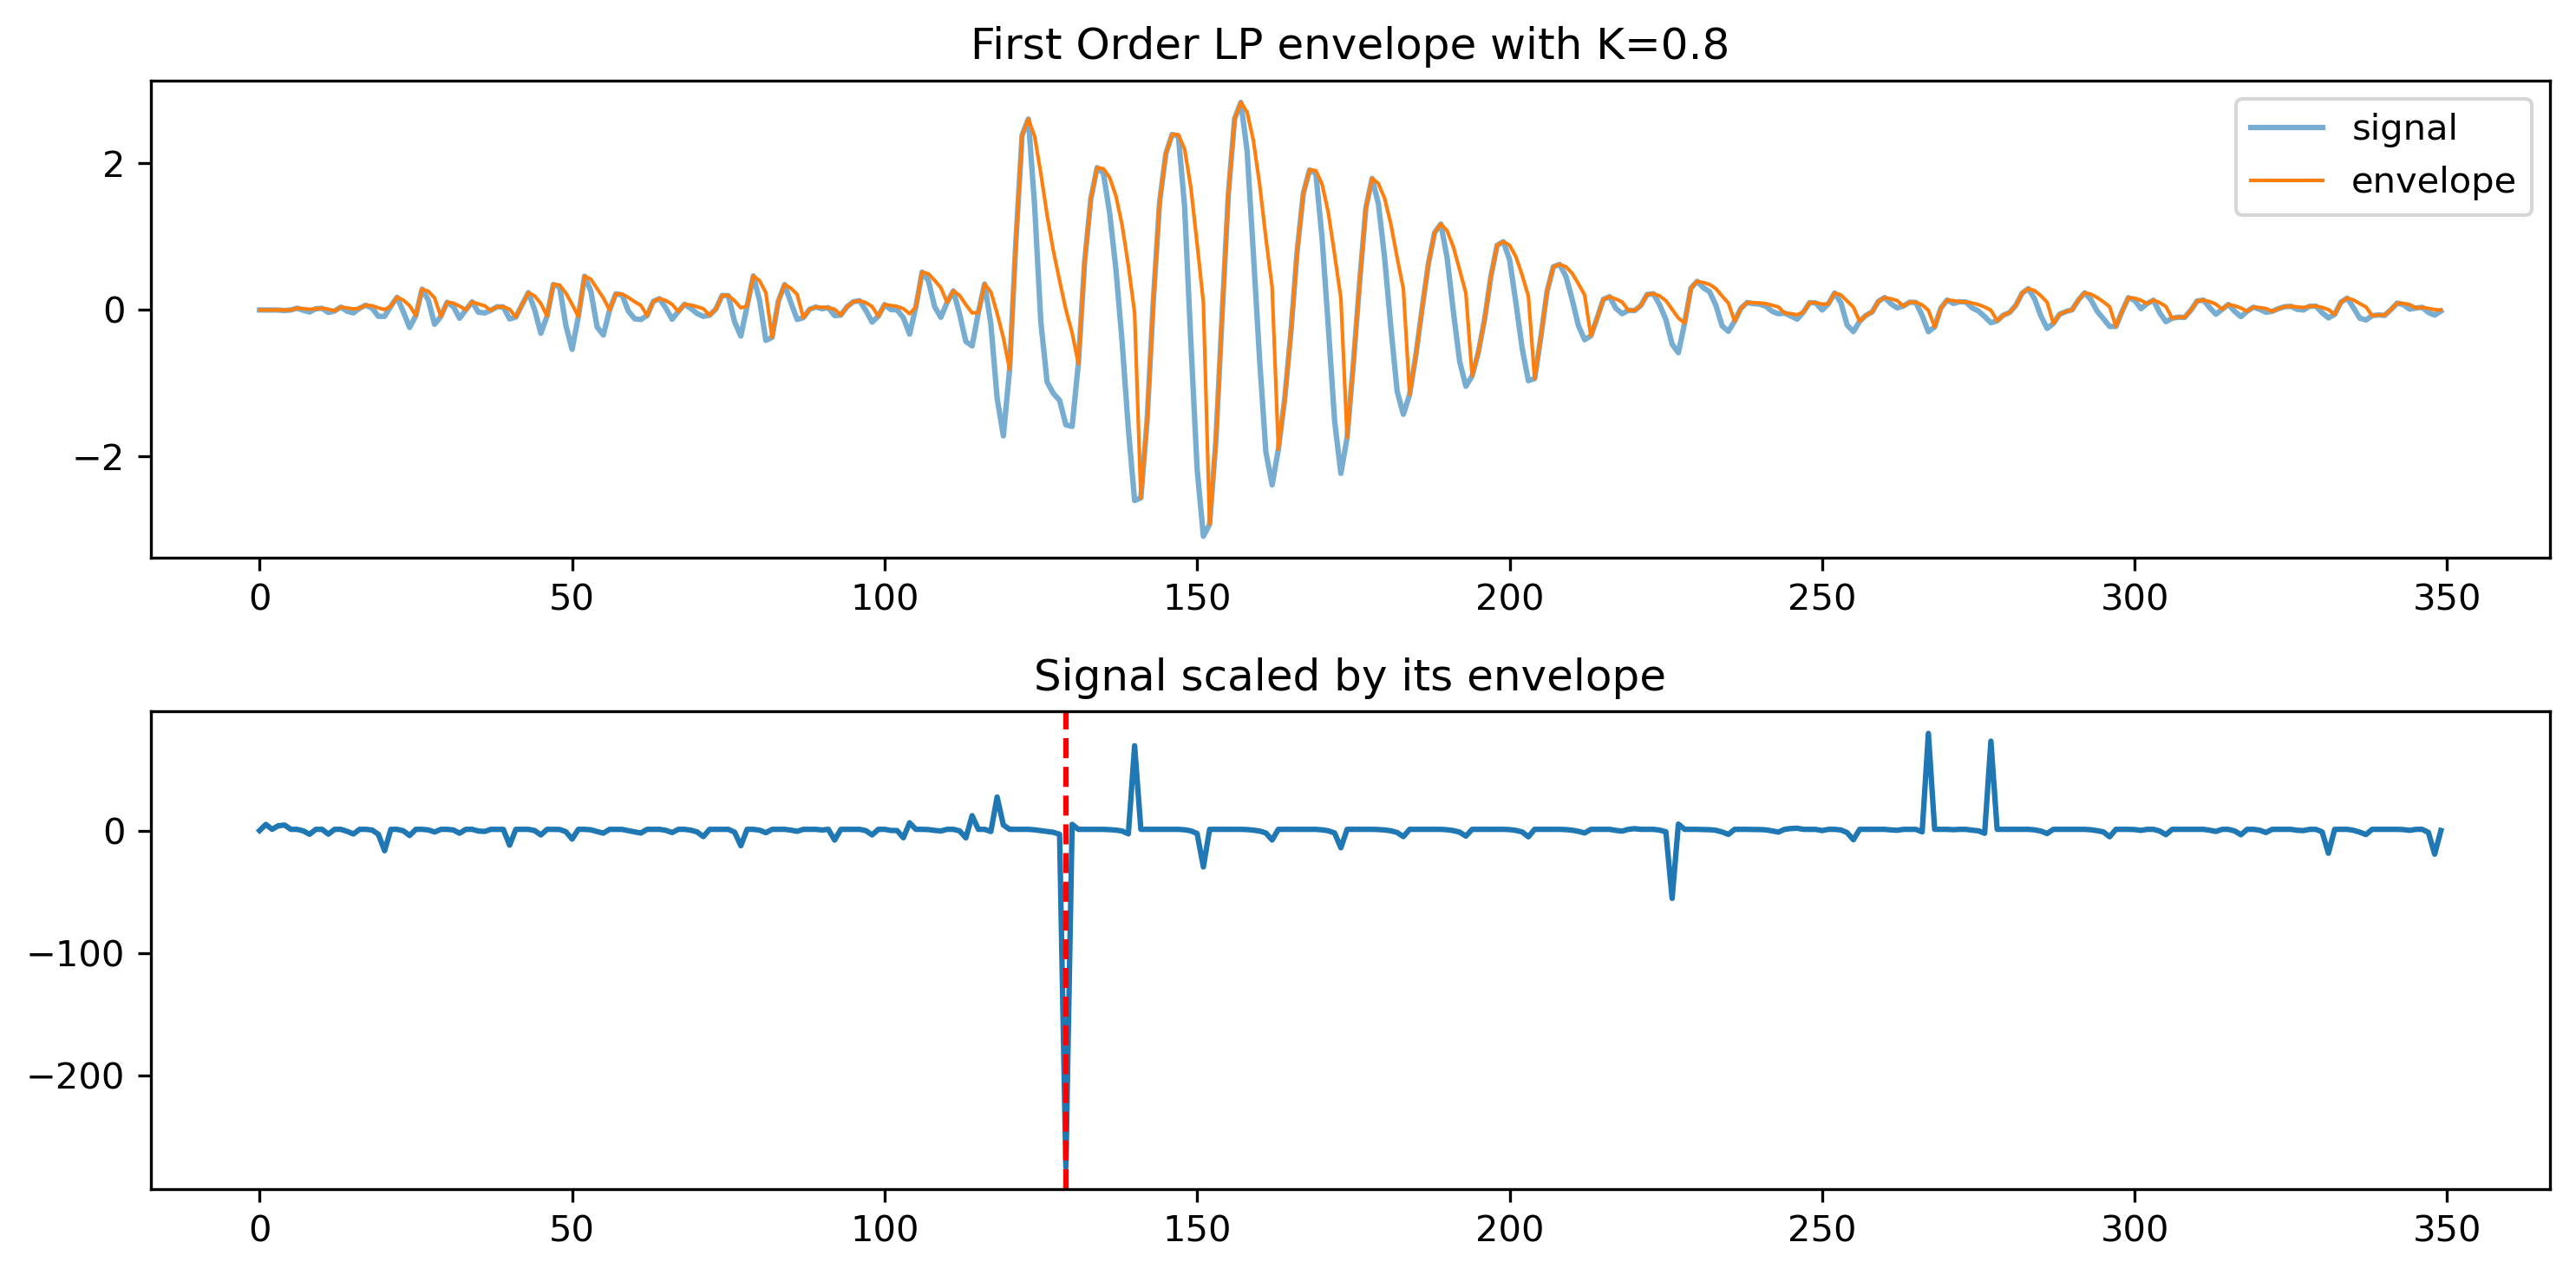

In [118]:
sample_idx = 3
env_params = {'k_env': 0.8}
env, sig_scaledbyenv, argmin_sig_env = plot_envelope(waveforms[0, 500:850, sample_idx], title='First Order LP envelope with K=0.8', envelope_function=envelope_first_order_lp, **env_params)

In [120]:
sig_scaledbyenv[argmin_sig_env], waveforms[0, argmin_sig_env, sample_idx], env[argmin_sig_env]

(-274.5642337573632, -7.688769715870232e-05, 0.005706826997197489)

/tmp/ipykernel_24663/4043581983.py:7: RuntimeWarning: divide by zero encountered in divide
  waveforms[0, argmin_sig_env, sample_idx], envelope[argmin_sig_env], waveforms[0, argmin_sig_env, sample_idx]/envelope[argmin_sig_env]


(array([2.30705031e-05, 6.98109015e-05]), array([0., 0.]), array([inf, inf]))

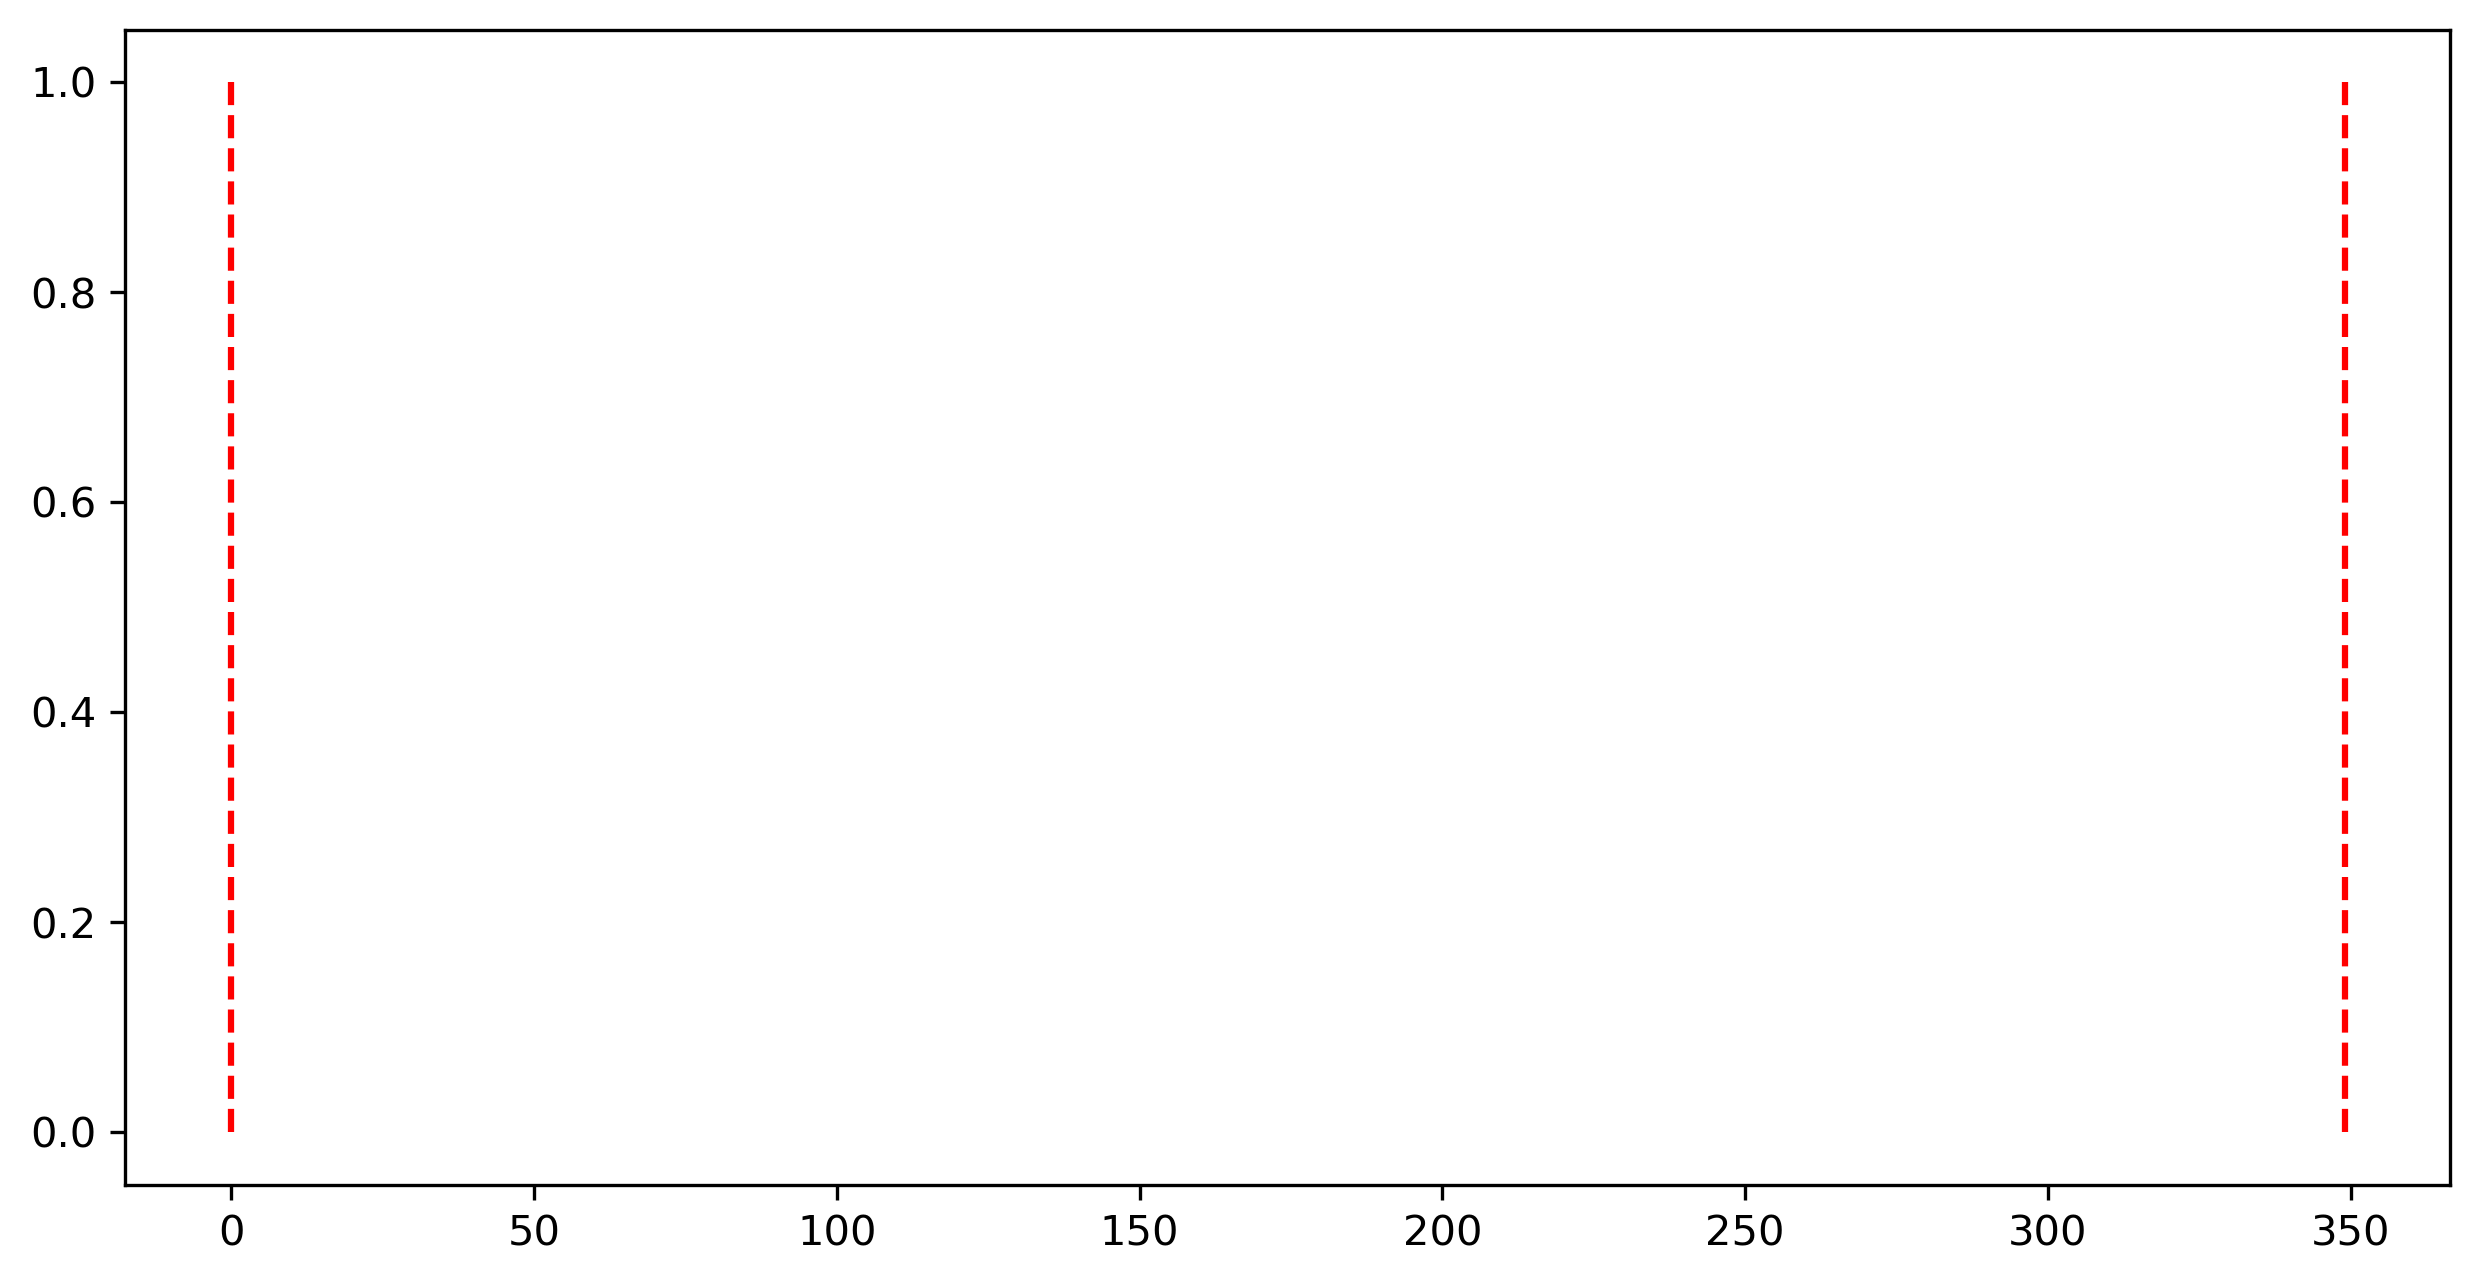

In [110]:
envelope = envelope_first_order_lp(waveforms[0, 500:850, sample_idx], **env_params)
argmin_sig_env = np.where(envelope==0)[0]

#plt.plot(waveforms[0, 500:850, sample_idx]/envelope)
plt.vlines(argmin_sig_env, 0, 1, color='r', linestyle='--')

waveforms[0, argmin_sig_env, sample_idx], envelope[argmin_sig_env], waveforms[0, argmin_sig_env, sample_idx]/envelope[argmin_sig_env]

Meaningless envelope. 

In [89]:
def envelope_third_order_lp(signal, k_env1, k_env2, k_env3):
    envelope = np.zeros(len(signal))
    for i in range(3, len(signal)-1):
        if signal[i] > signal[i-1]:
            envelope[i] = signal[i]
        else:
            envelope[i] = k_env1*envelope[i-1] + k_env2*envelope[i-2] + k_env3*envelope[i-3] + (1-k_env1)*signal[i] # first order discrete time low pass filter
    return envelope

/tmp/ipykernel_24663/3749355816.py:13: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(signal/(envelope))


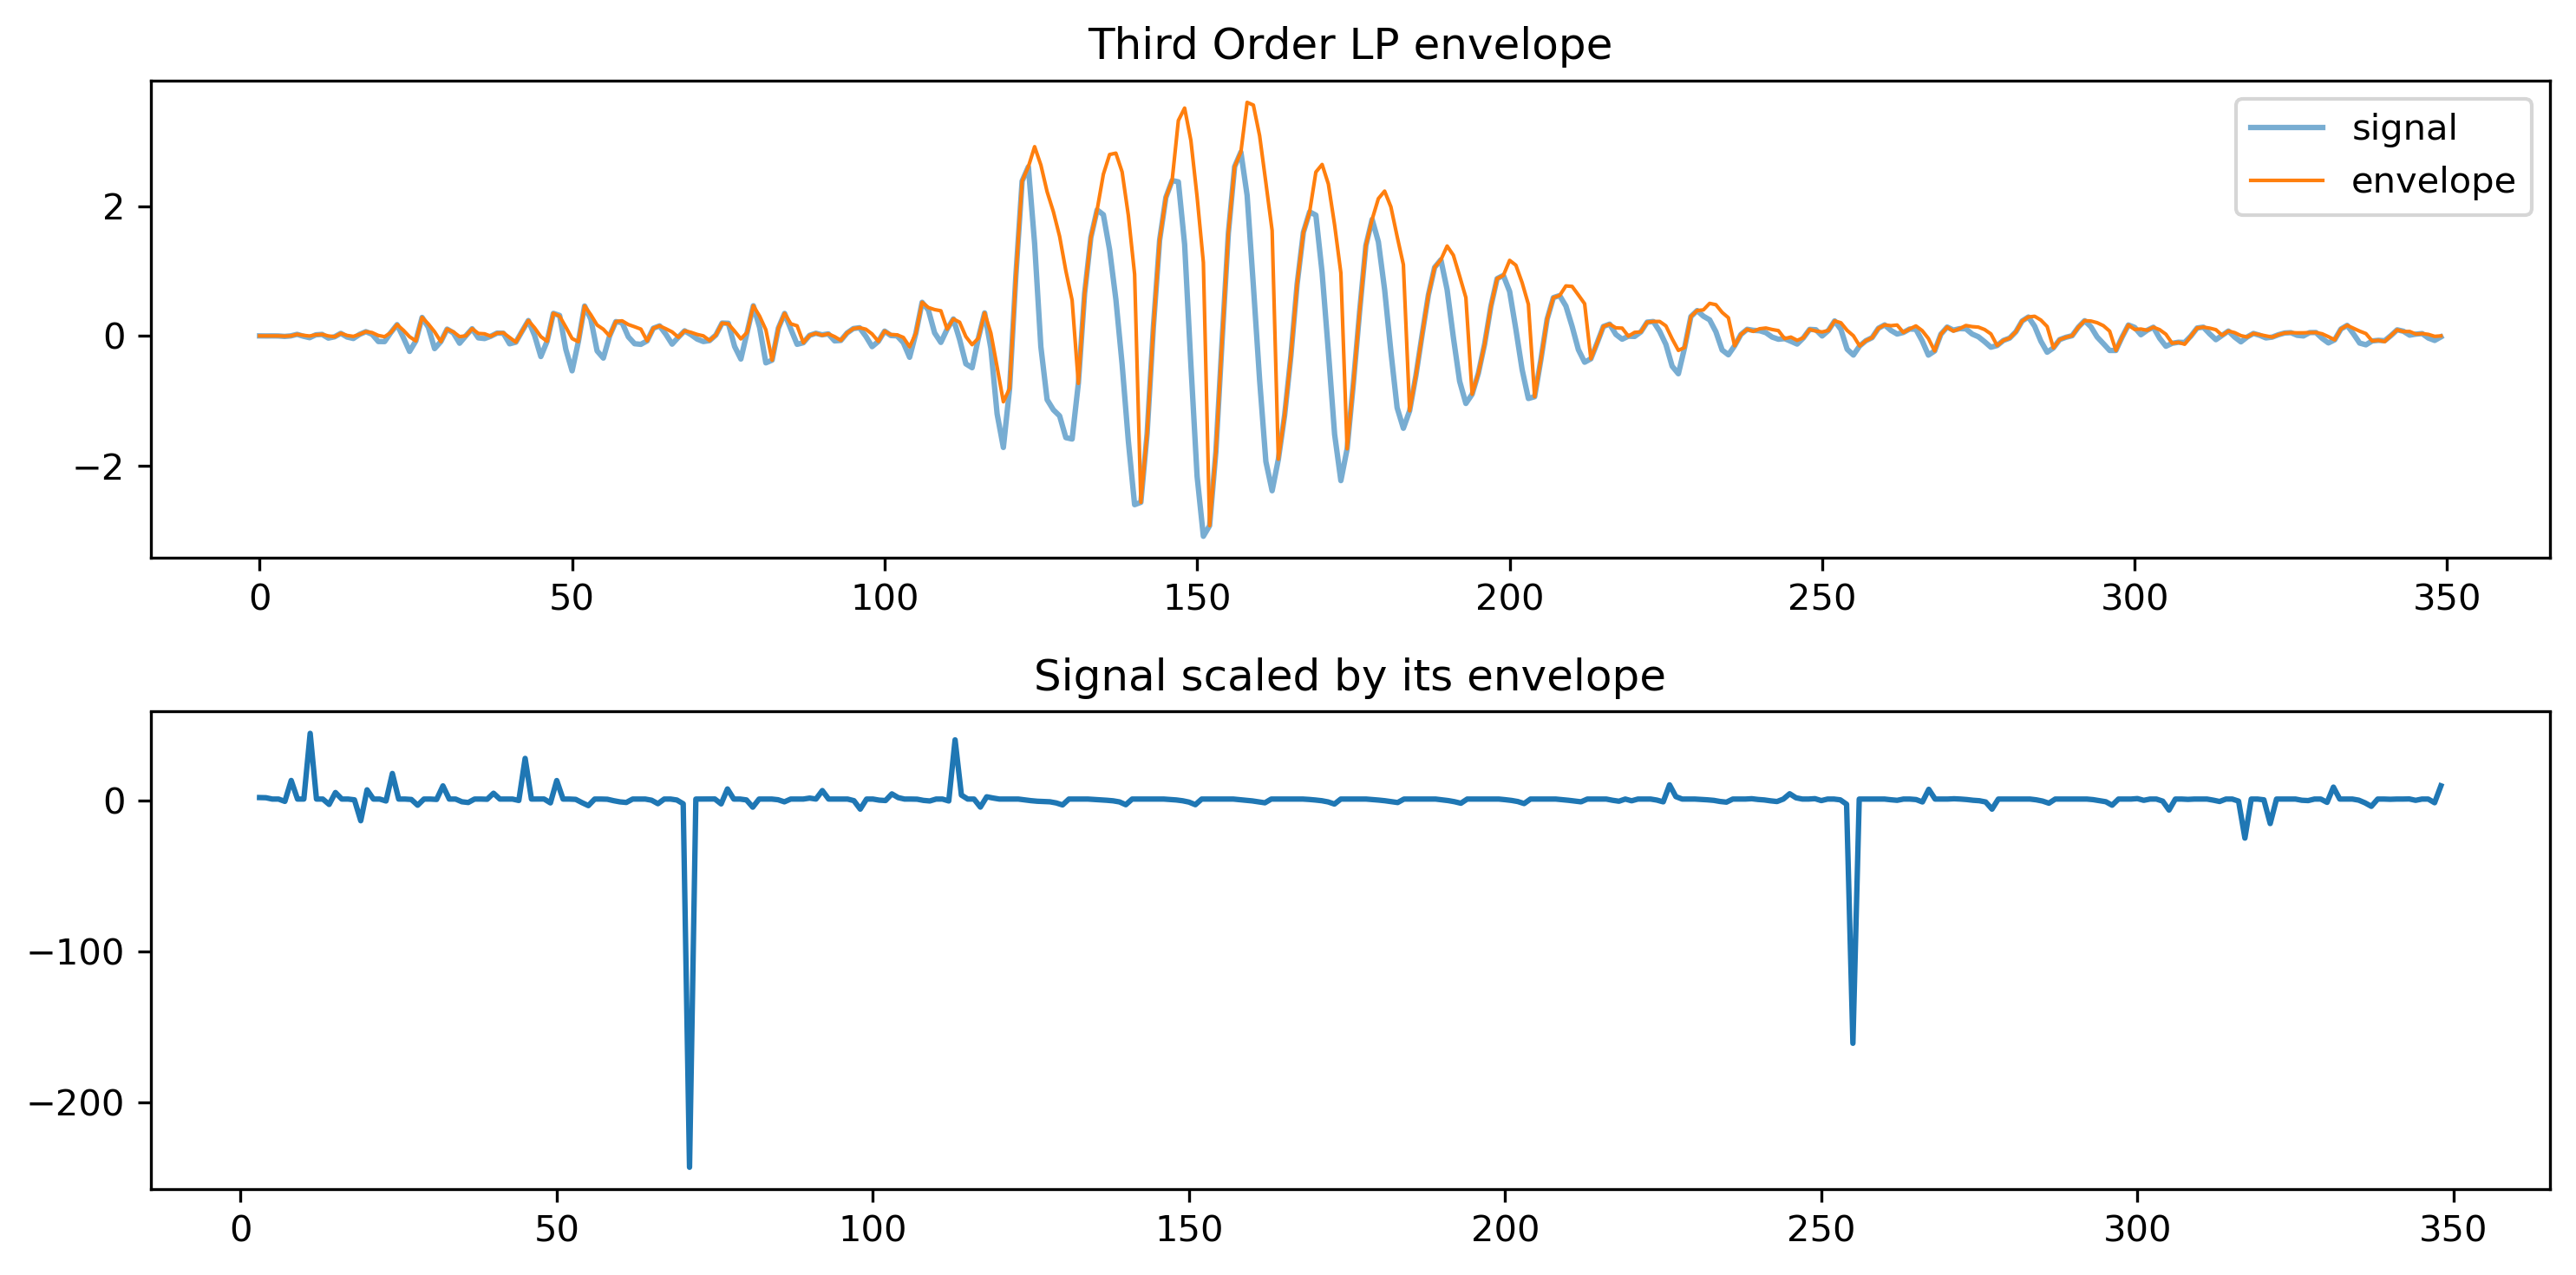

In [90]:
sample_idx = 3
env_params = {'k_env1': 0.5, 'k_env2': 0.3, 'k_env3': 0.2}
plot_envelope(waveforms[0, 500:850, sample_idx], title='Third Order LP envelope', envelope_function=envelope_third_order_lp, **env_params)

Meaningless envelope still. 

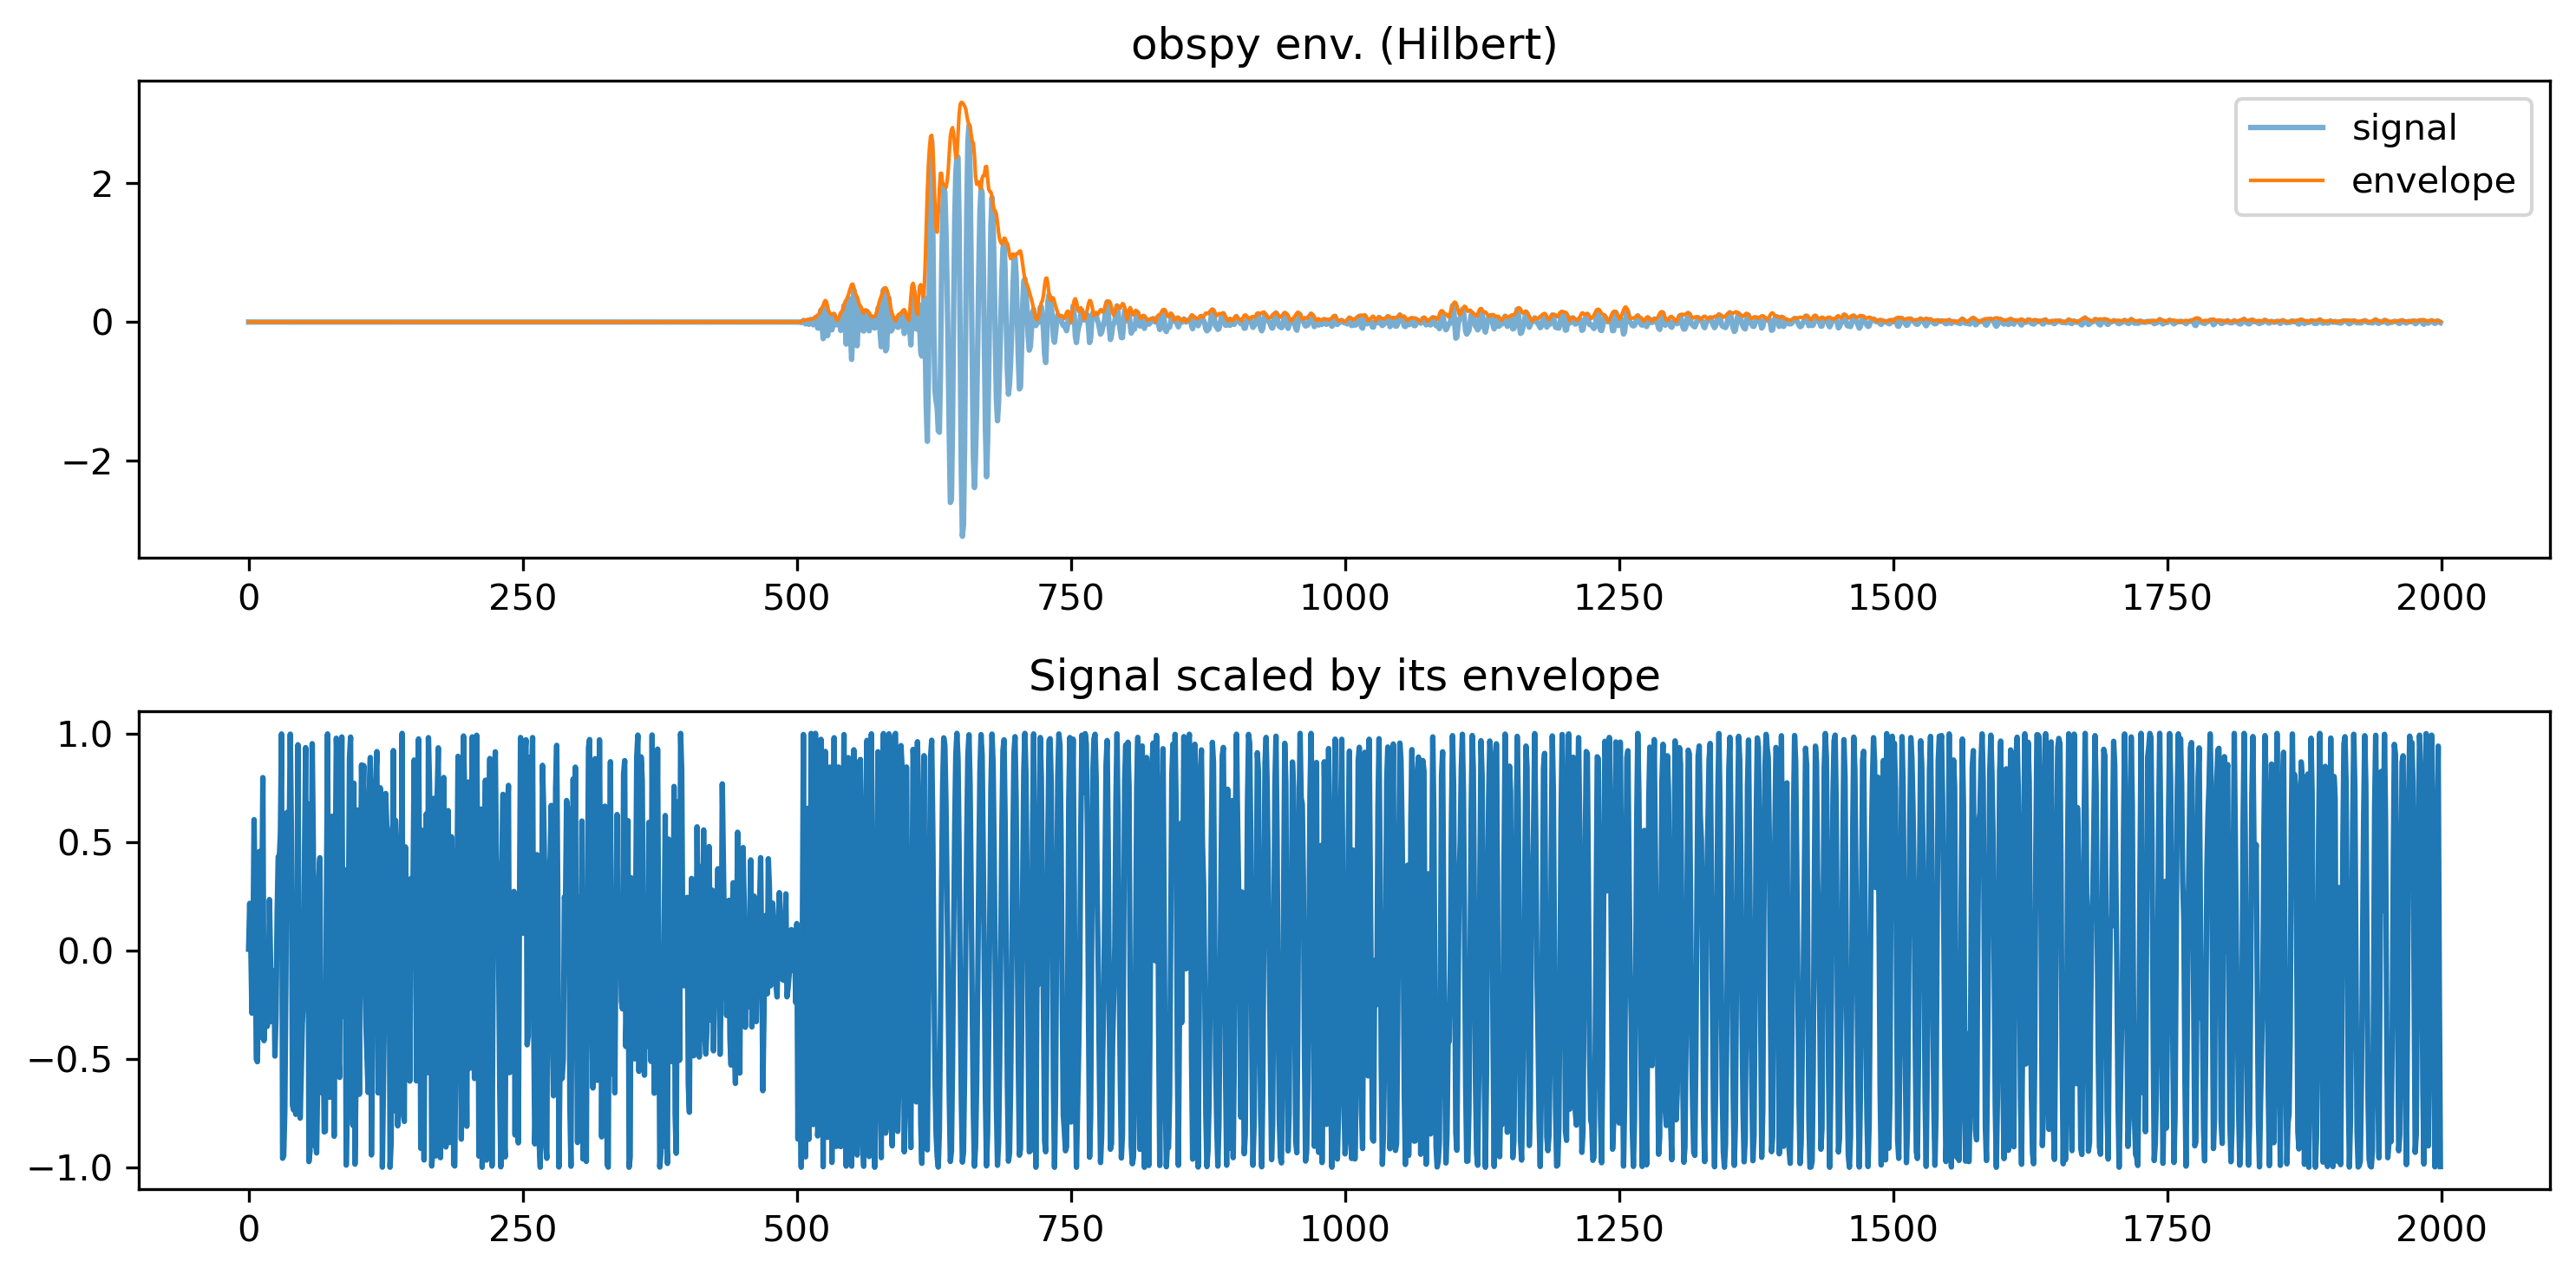

False


In [65]:
import obspy.signal.filter

sample_idx = 3
plot_envelope(waveforms[0, :2000, sample_idx], title='obspy env. (Hilbert)', envelope_function=obspy.signal.filter.envelope)

print(np.any(np.isnan(waveforms[0, :, sample_idx])))

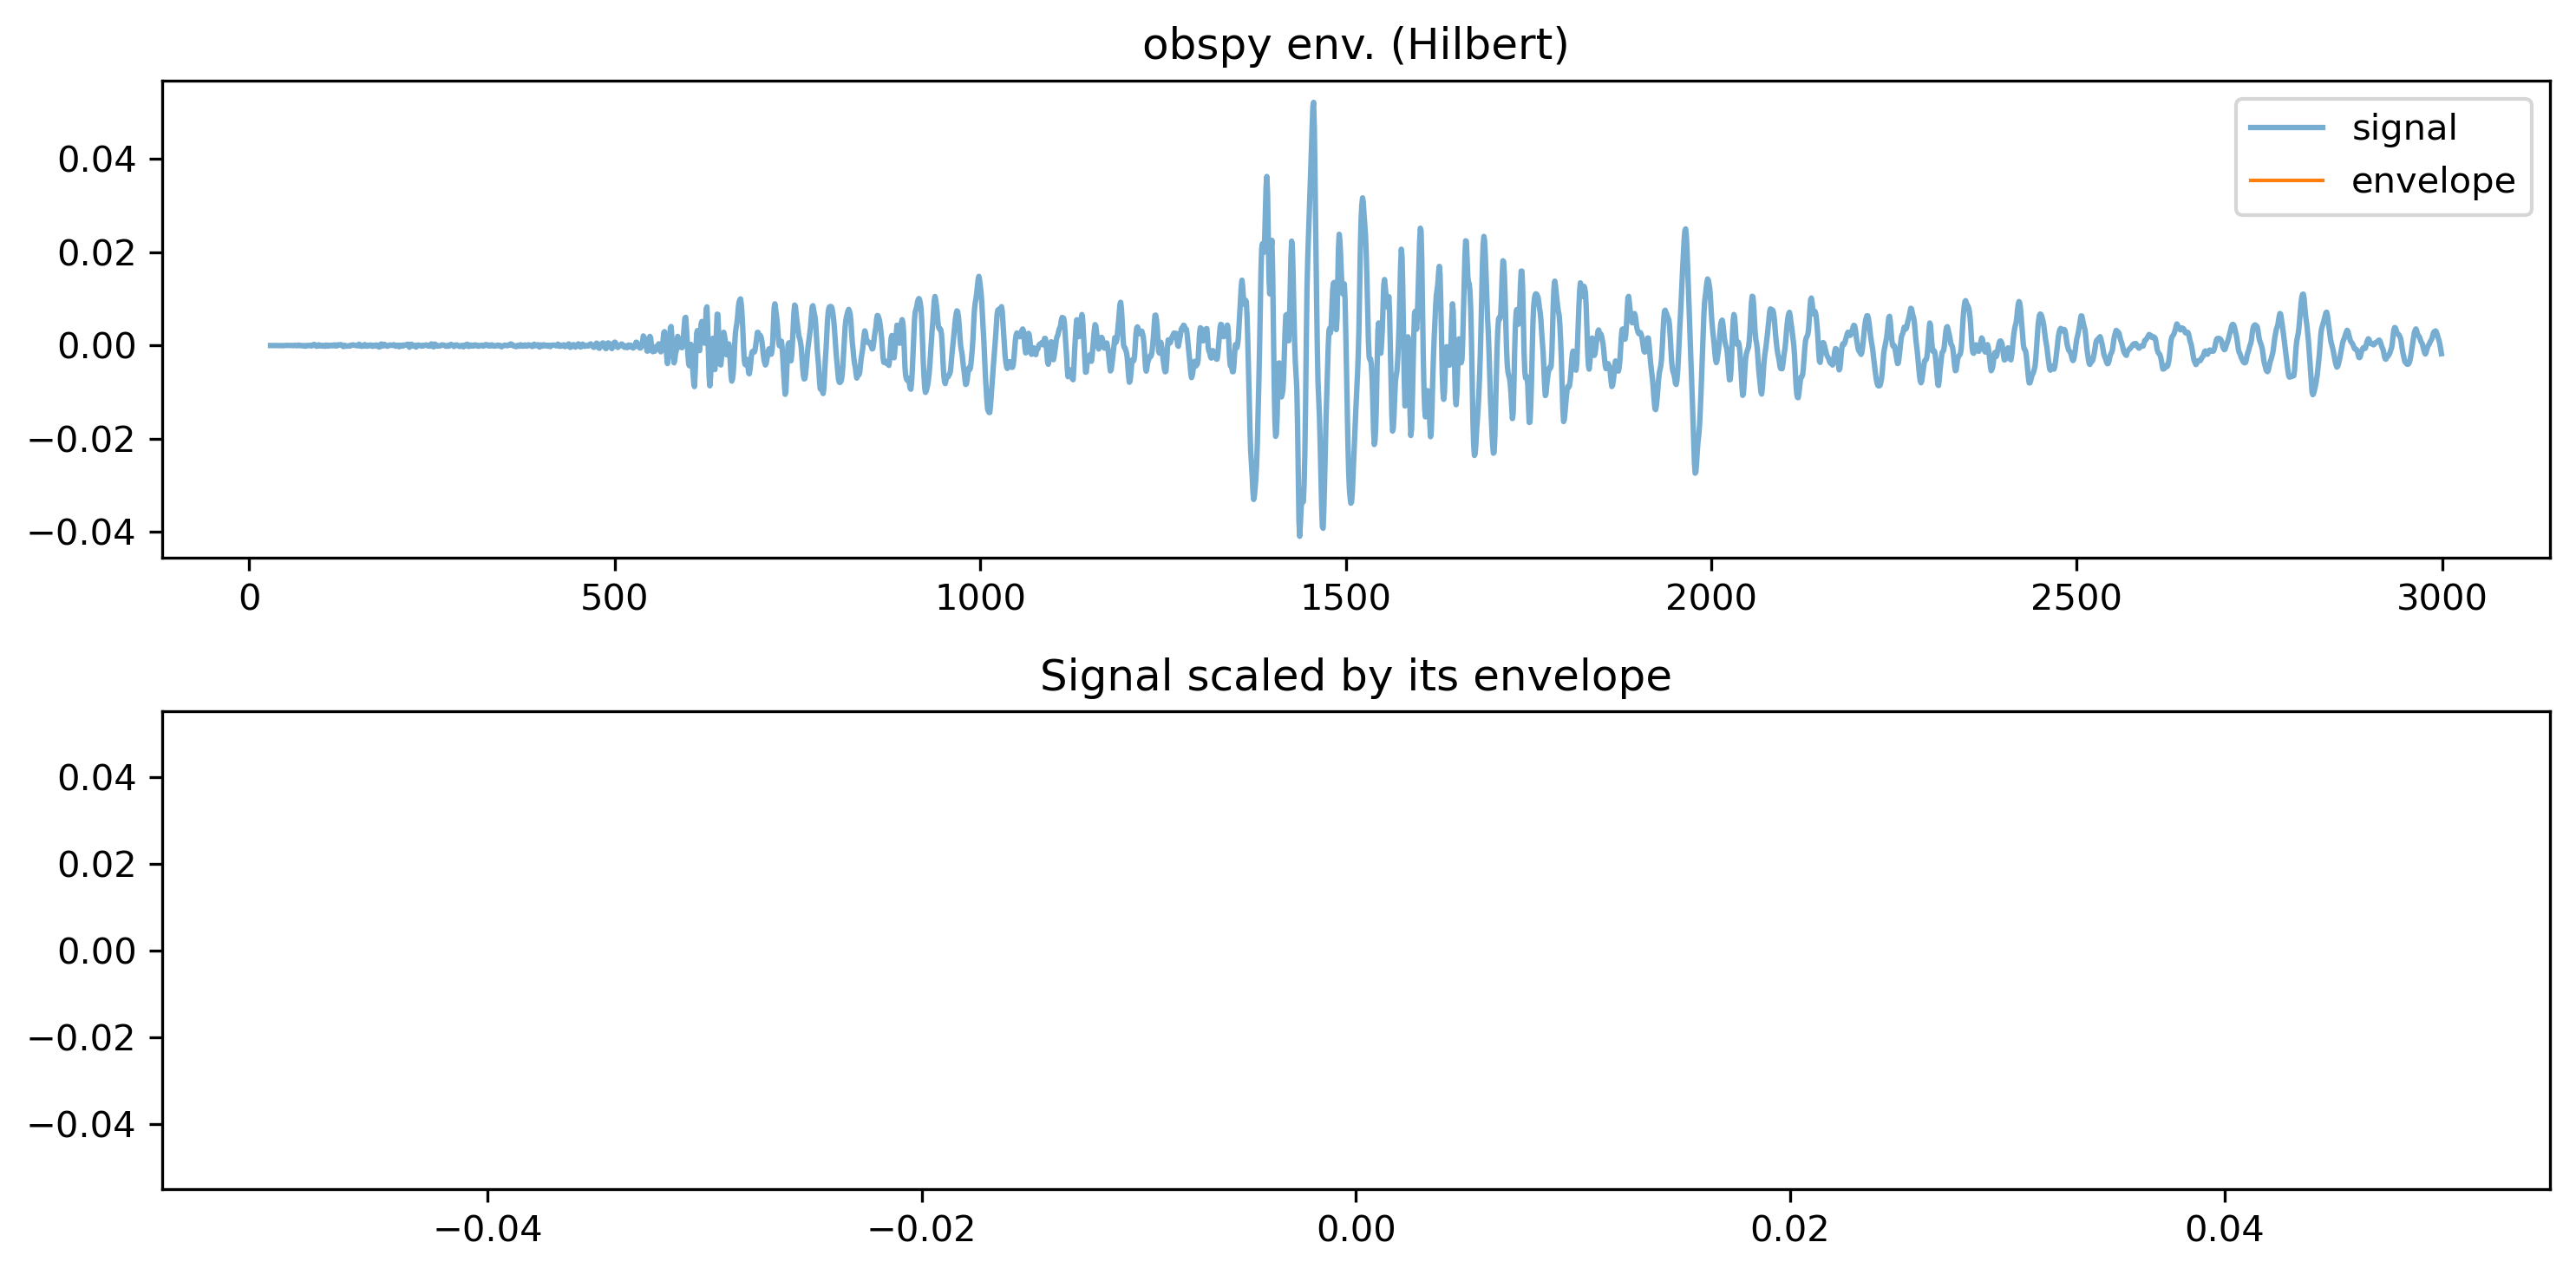

True


In [66]:
sample_idx = 0
plot_envelope(waveforms[0, :3000, sample_idx], title='obspy env. (Hilbert)', envelope_function=obspy.signal.filter.envelope)

print(np.any(np.isnan(waveforms[0, :, sample_idx])))

Envelope is NaN because the waveforms contains NaNs. 

In [67]:
def plot_nans(signal):
    # Get the indices where NaN values are present
    nan_indices = np.where(np.isnan(signal))[0]

    # Get the indices where NaN values are not present
    not_nan_indices = np.where(~np.isnan(signal))[0]

    # Plot the non-NaN values
    plt.plot(not_nan_indices, signal[not_nan_indices], 'b-', label='Data')

    # Plot the NaN values
    plt.plot(nan_indices, np.zeros_like(nan_indices), 'rx', label='NaN')

    plt.legend()
    plt.show()

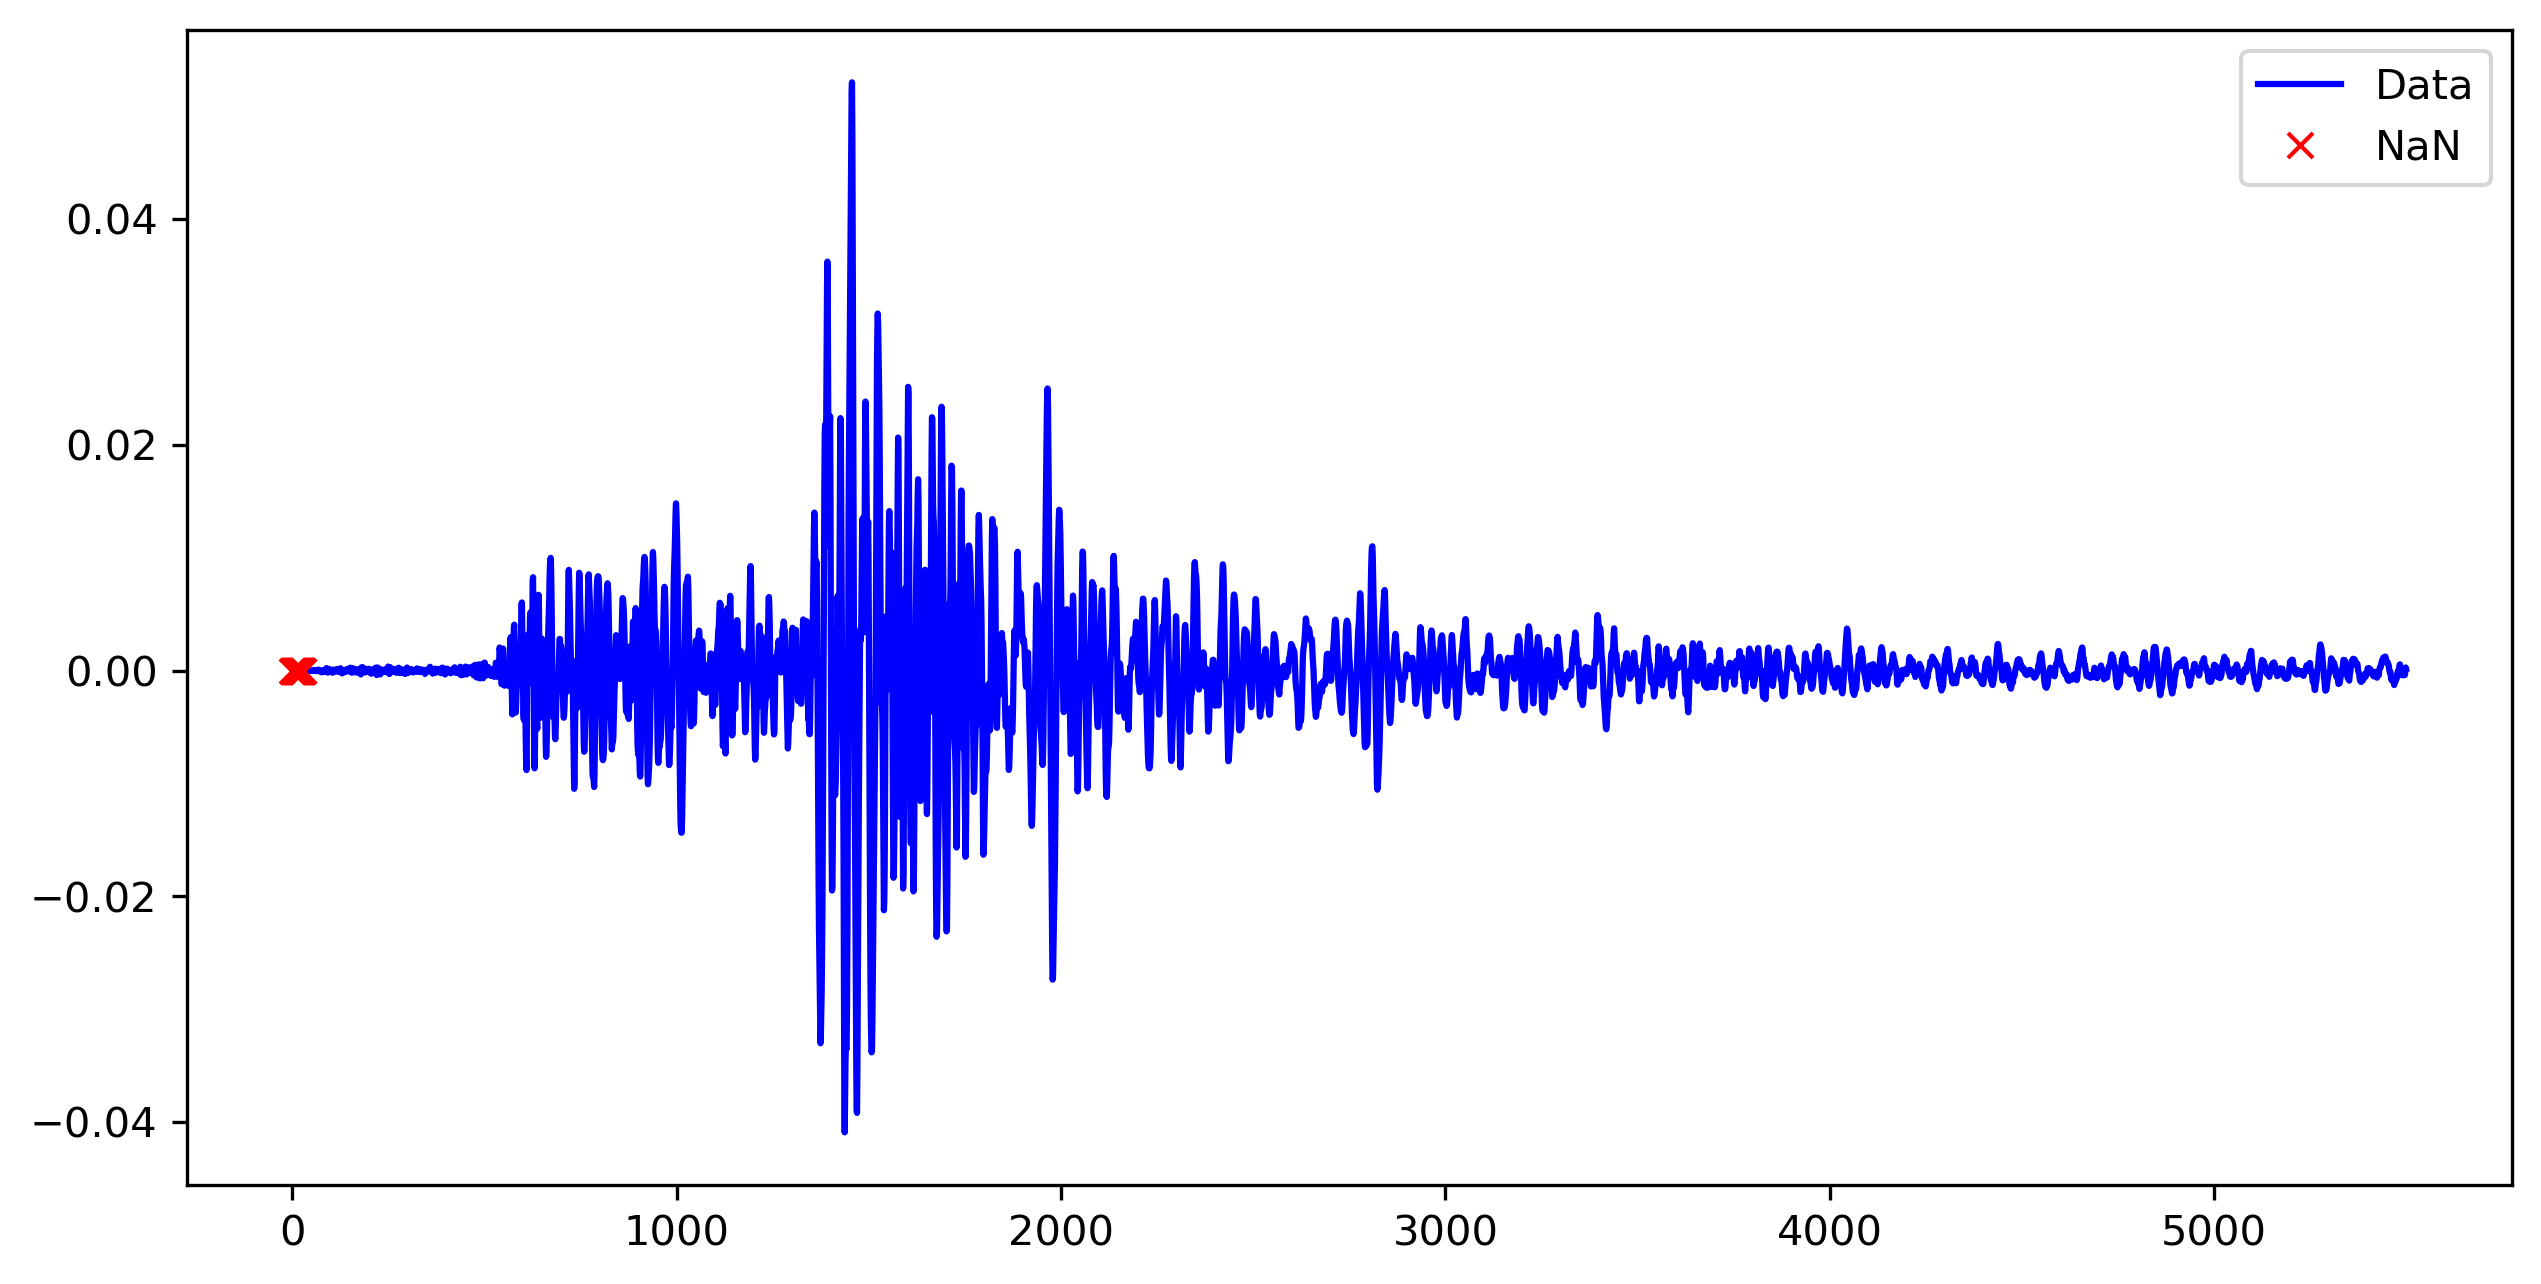

In [68]:
plot_nans(waveforms[0, :, sample_idx])

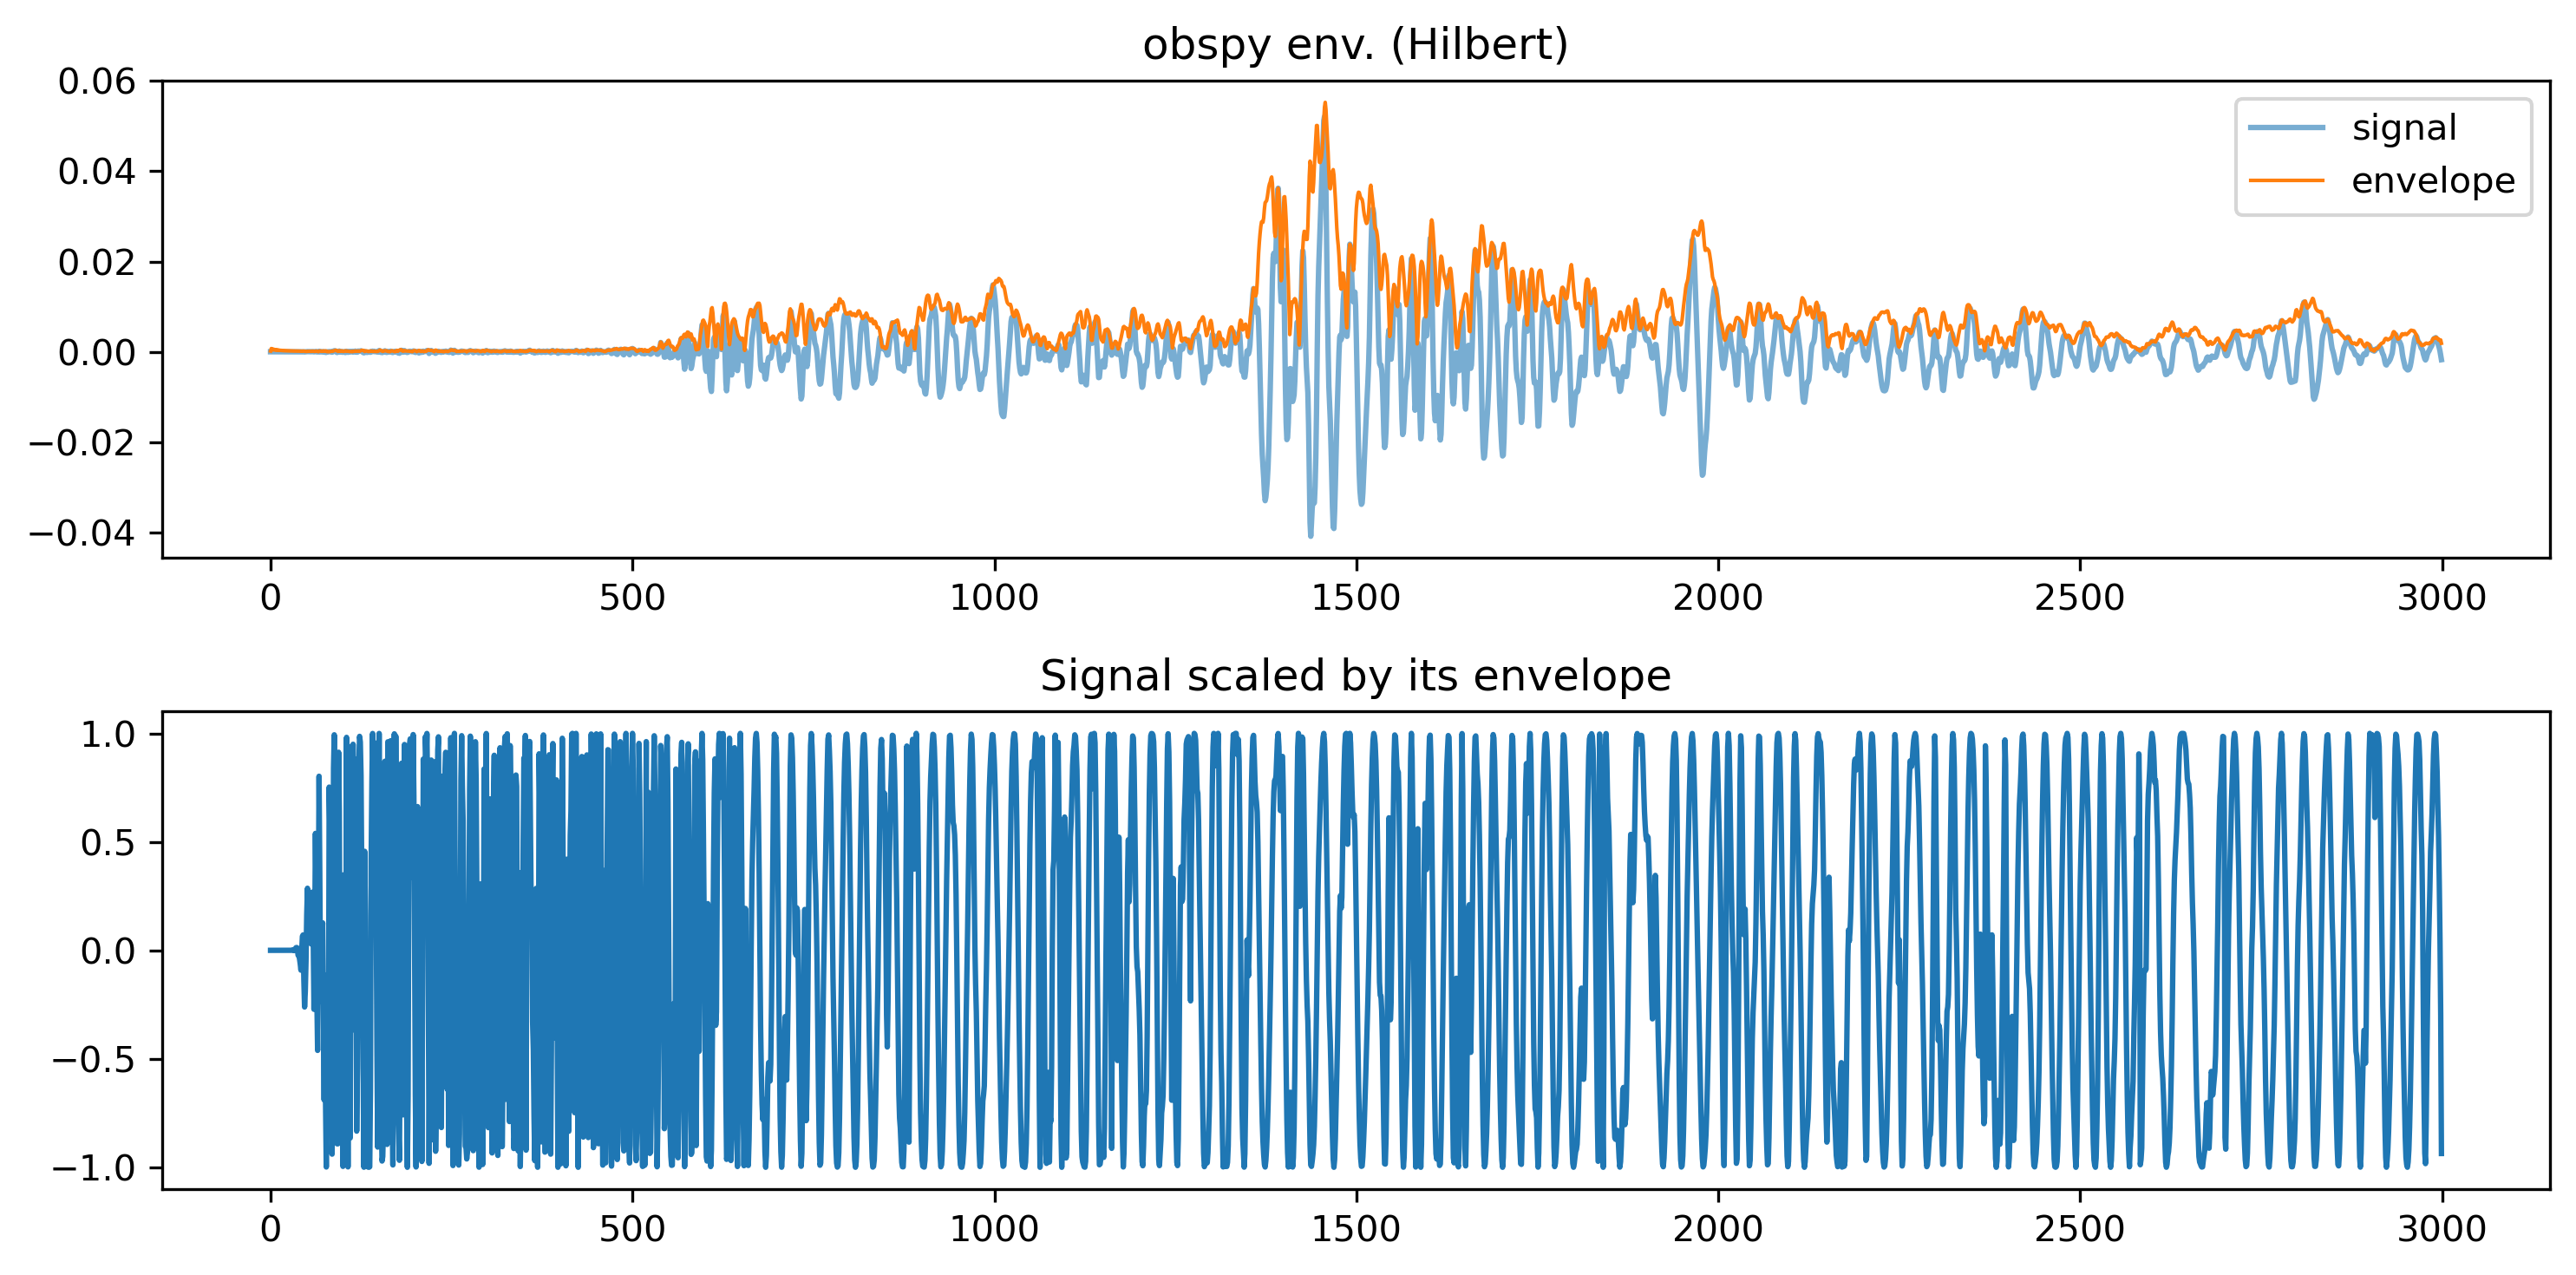

False


In [69]:
sample_idx = 0
waveform = np.nan_to_num(waveforms[0, :3000, sample_idx], nan=0) # since it seems that the NaNs are at the edges of the signal, we can just replace them with 0
plot_envelope(waveform, title='obspy env. (Hilbert)', envelope_function=obspy.signal.filter.envelope)

print(np.any(np.isnan(waveform)))

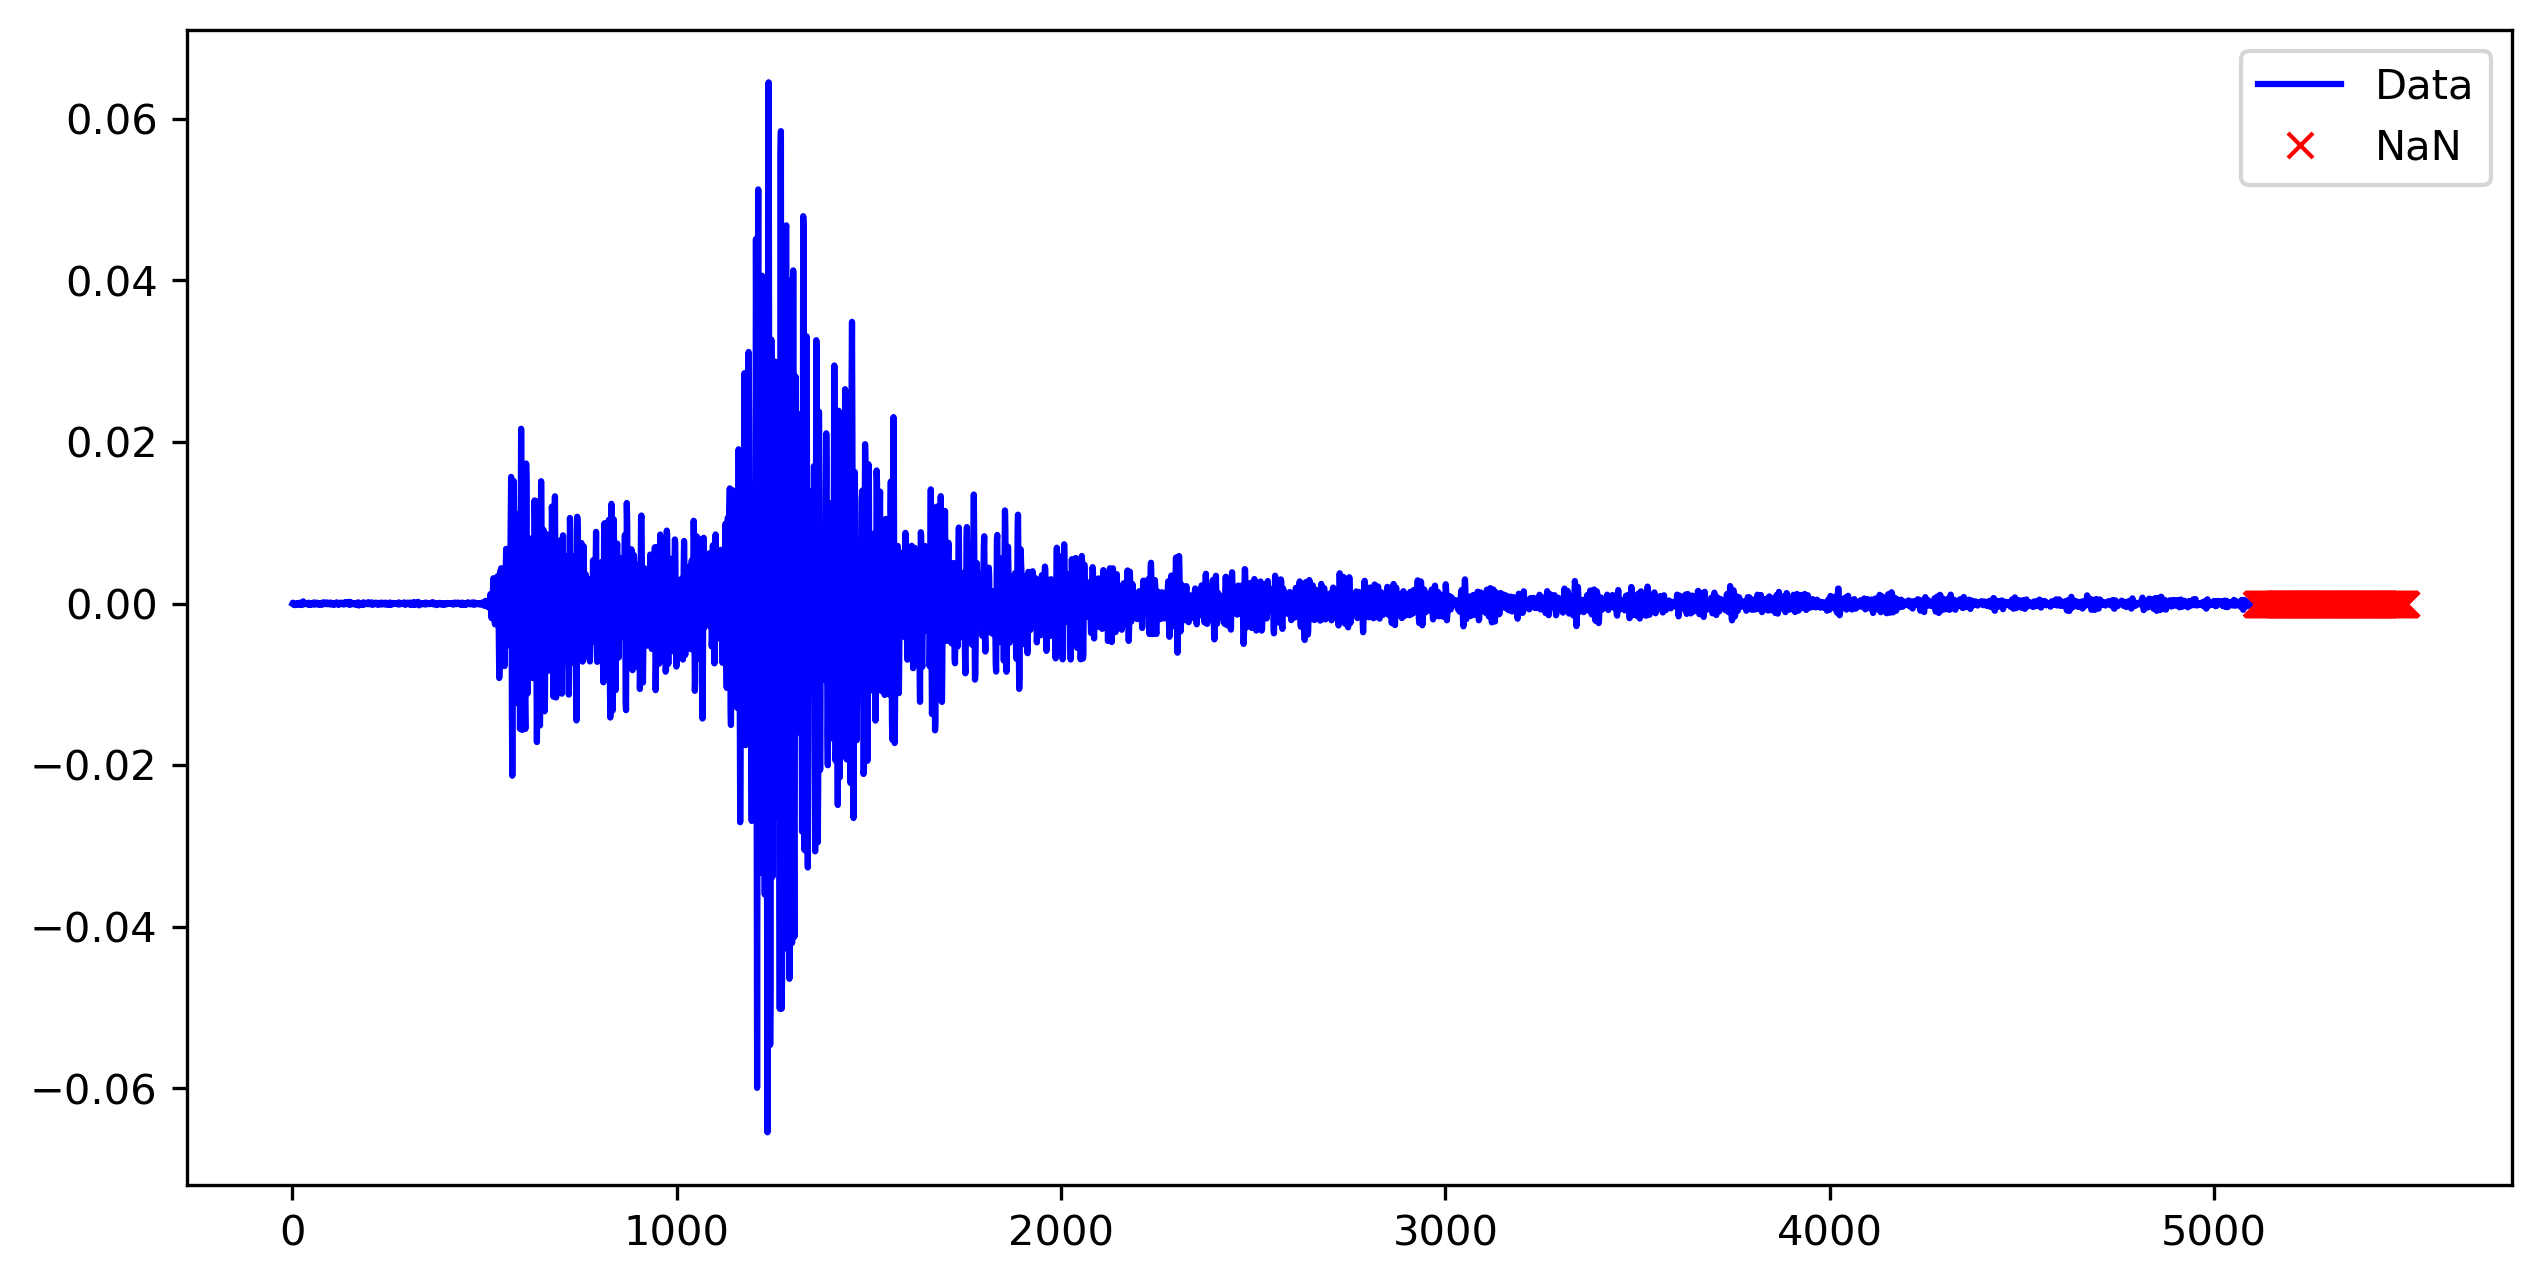

In [73]:
sample_idx = 1
waveform = waveforms[0, :, sample_idx]
plot_nans(waveform)

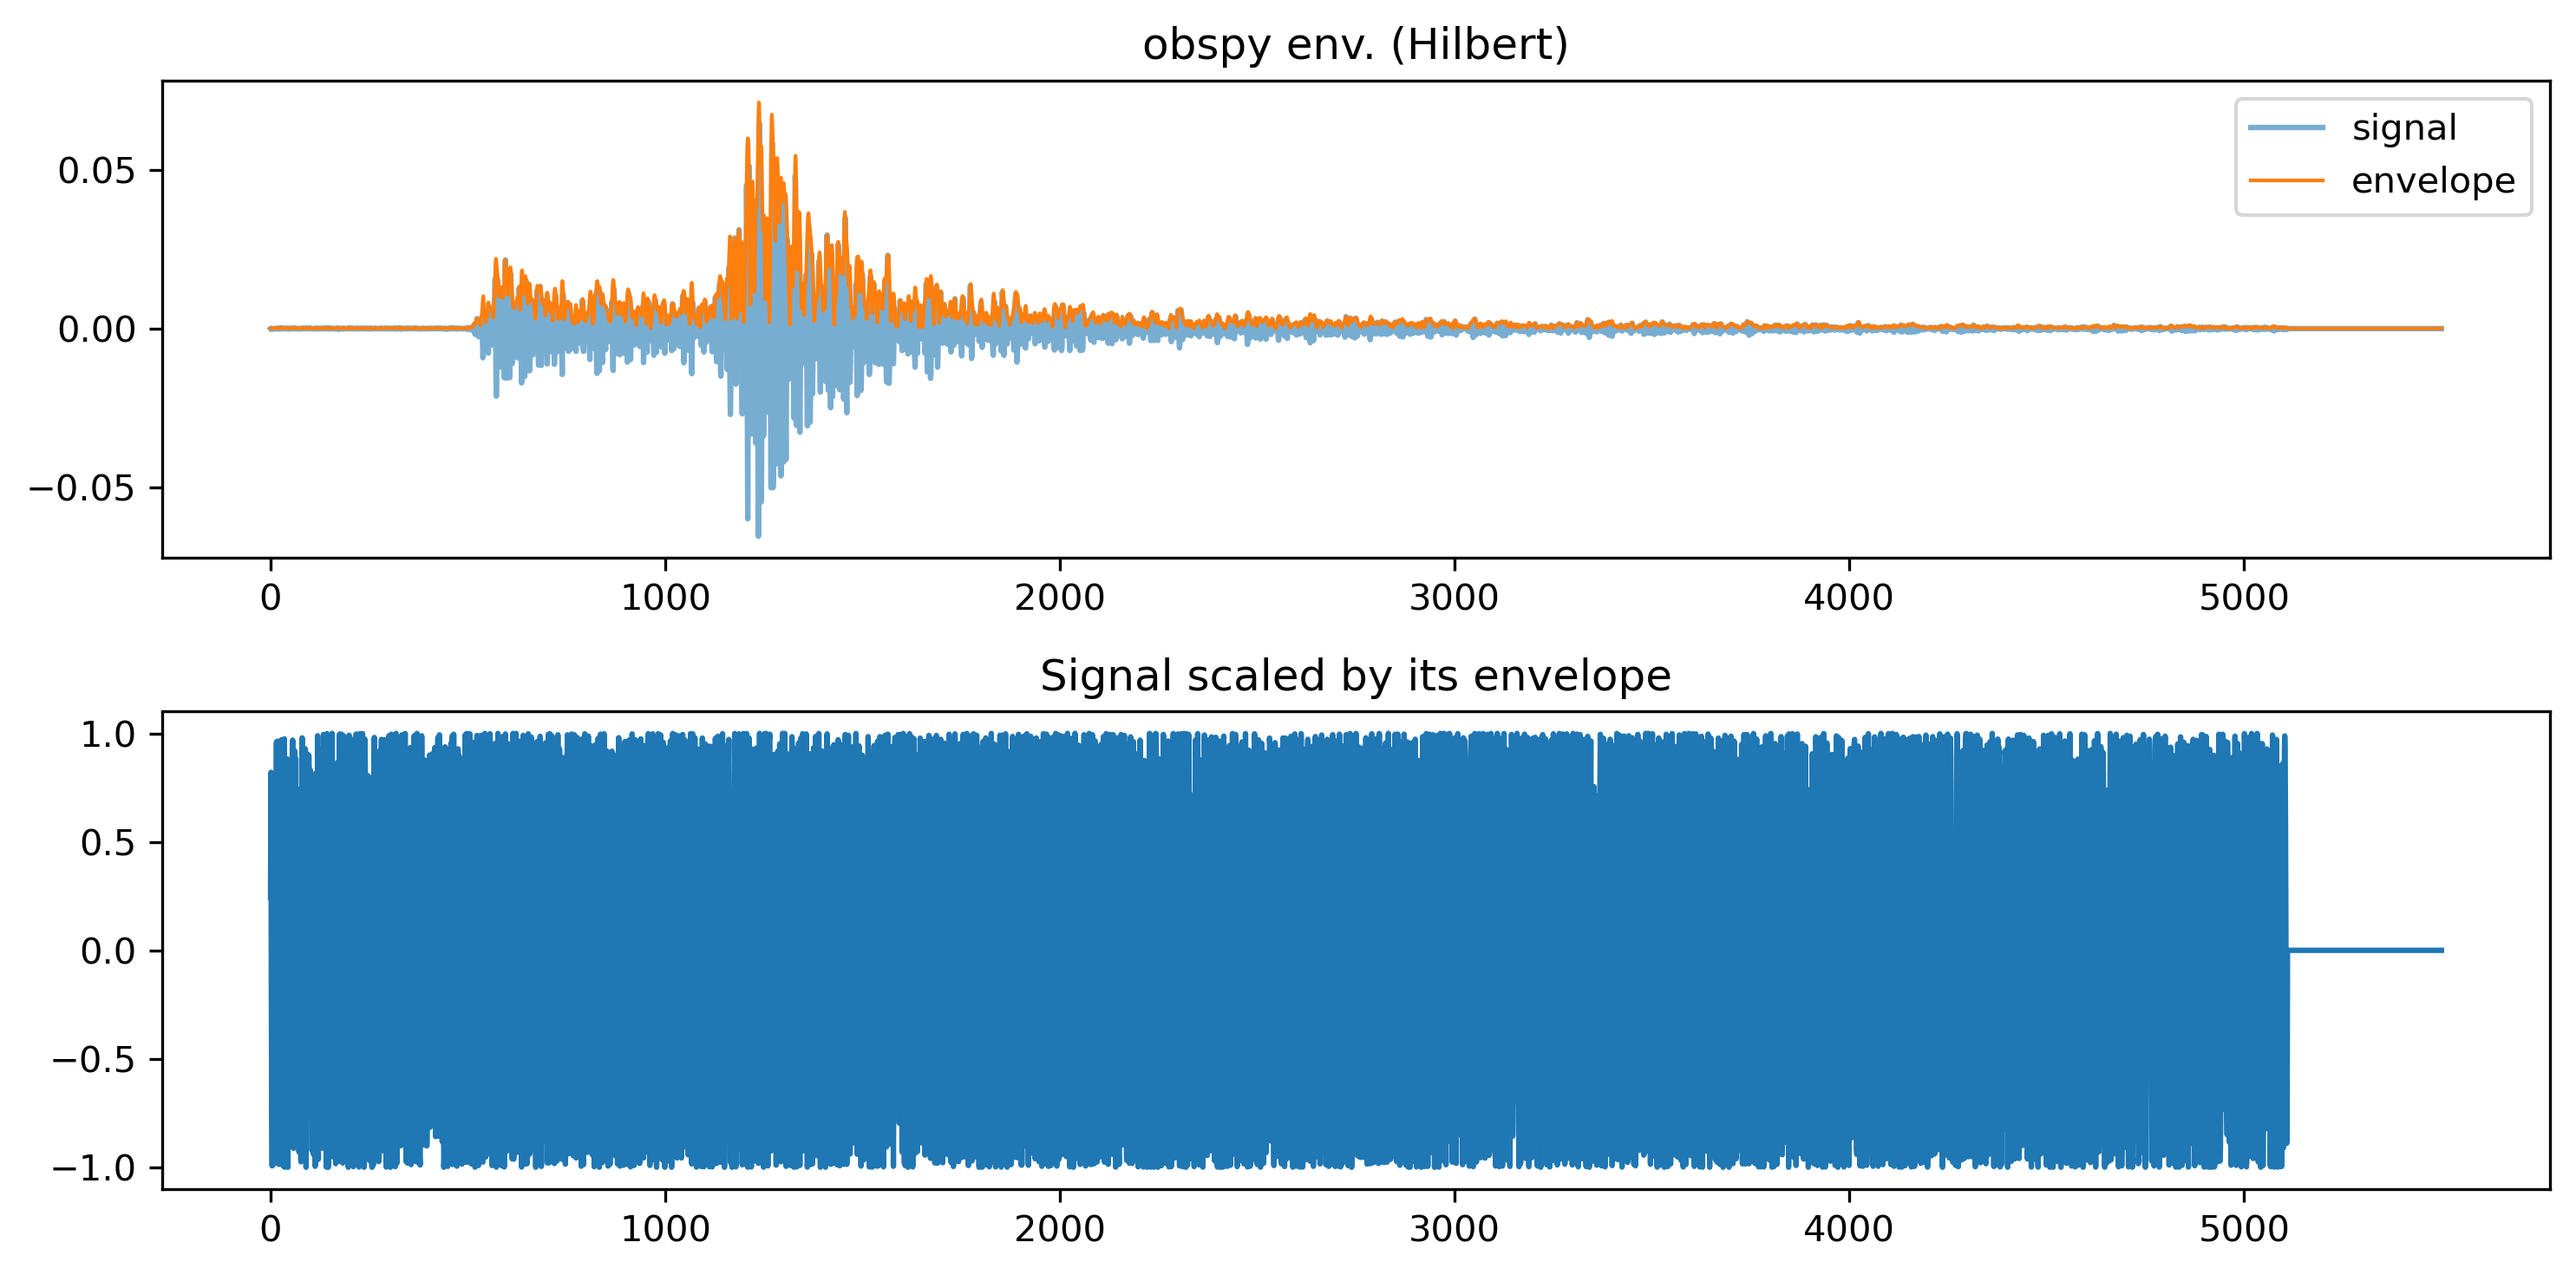

False


In [74]:
waveform = np.nan_to_num(waveform, nan=0) # since it seems that the NaNs are at the edges of the signal, we can just replace them with 0
plot_envelope(waveform, title='obspy env. (Hilbert)', envelope_function=obspy.signal.filter.envelope)

print(np.any(np.isnan(waveform)))

In [77]:
def _centered_window(x, window_len):
    assert window_len % 2, 'Centered Window has to have odd length'
    mid = window_len // 2
    pos = 0
    while pos < len(x):
        yield x[max(pos - mid, 0): min(pos + mid + 1, len(x))]
        pos += 1

def centered_max(x, window_len):
    out = [window.max() for window in _centered_window(x, window_len)]
    return np.array(out)

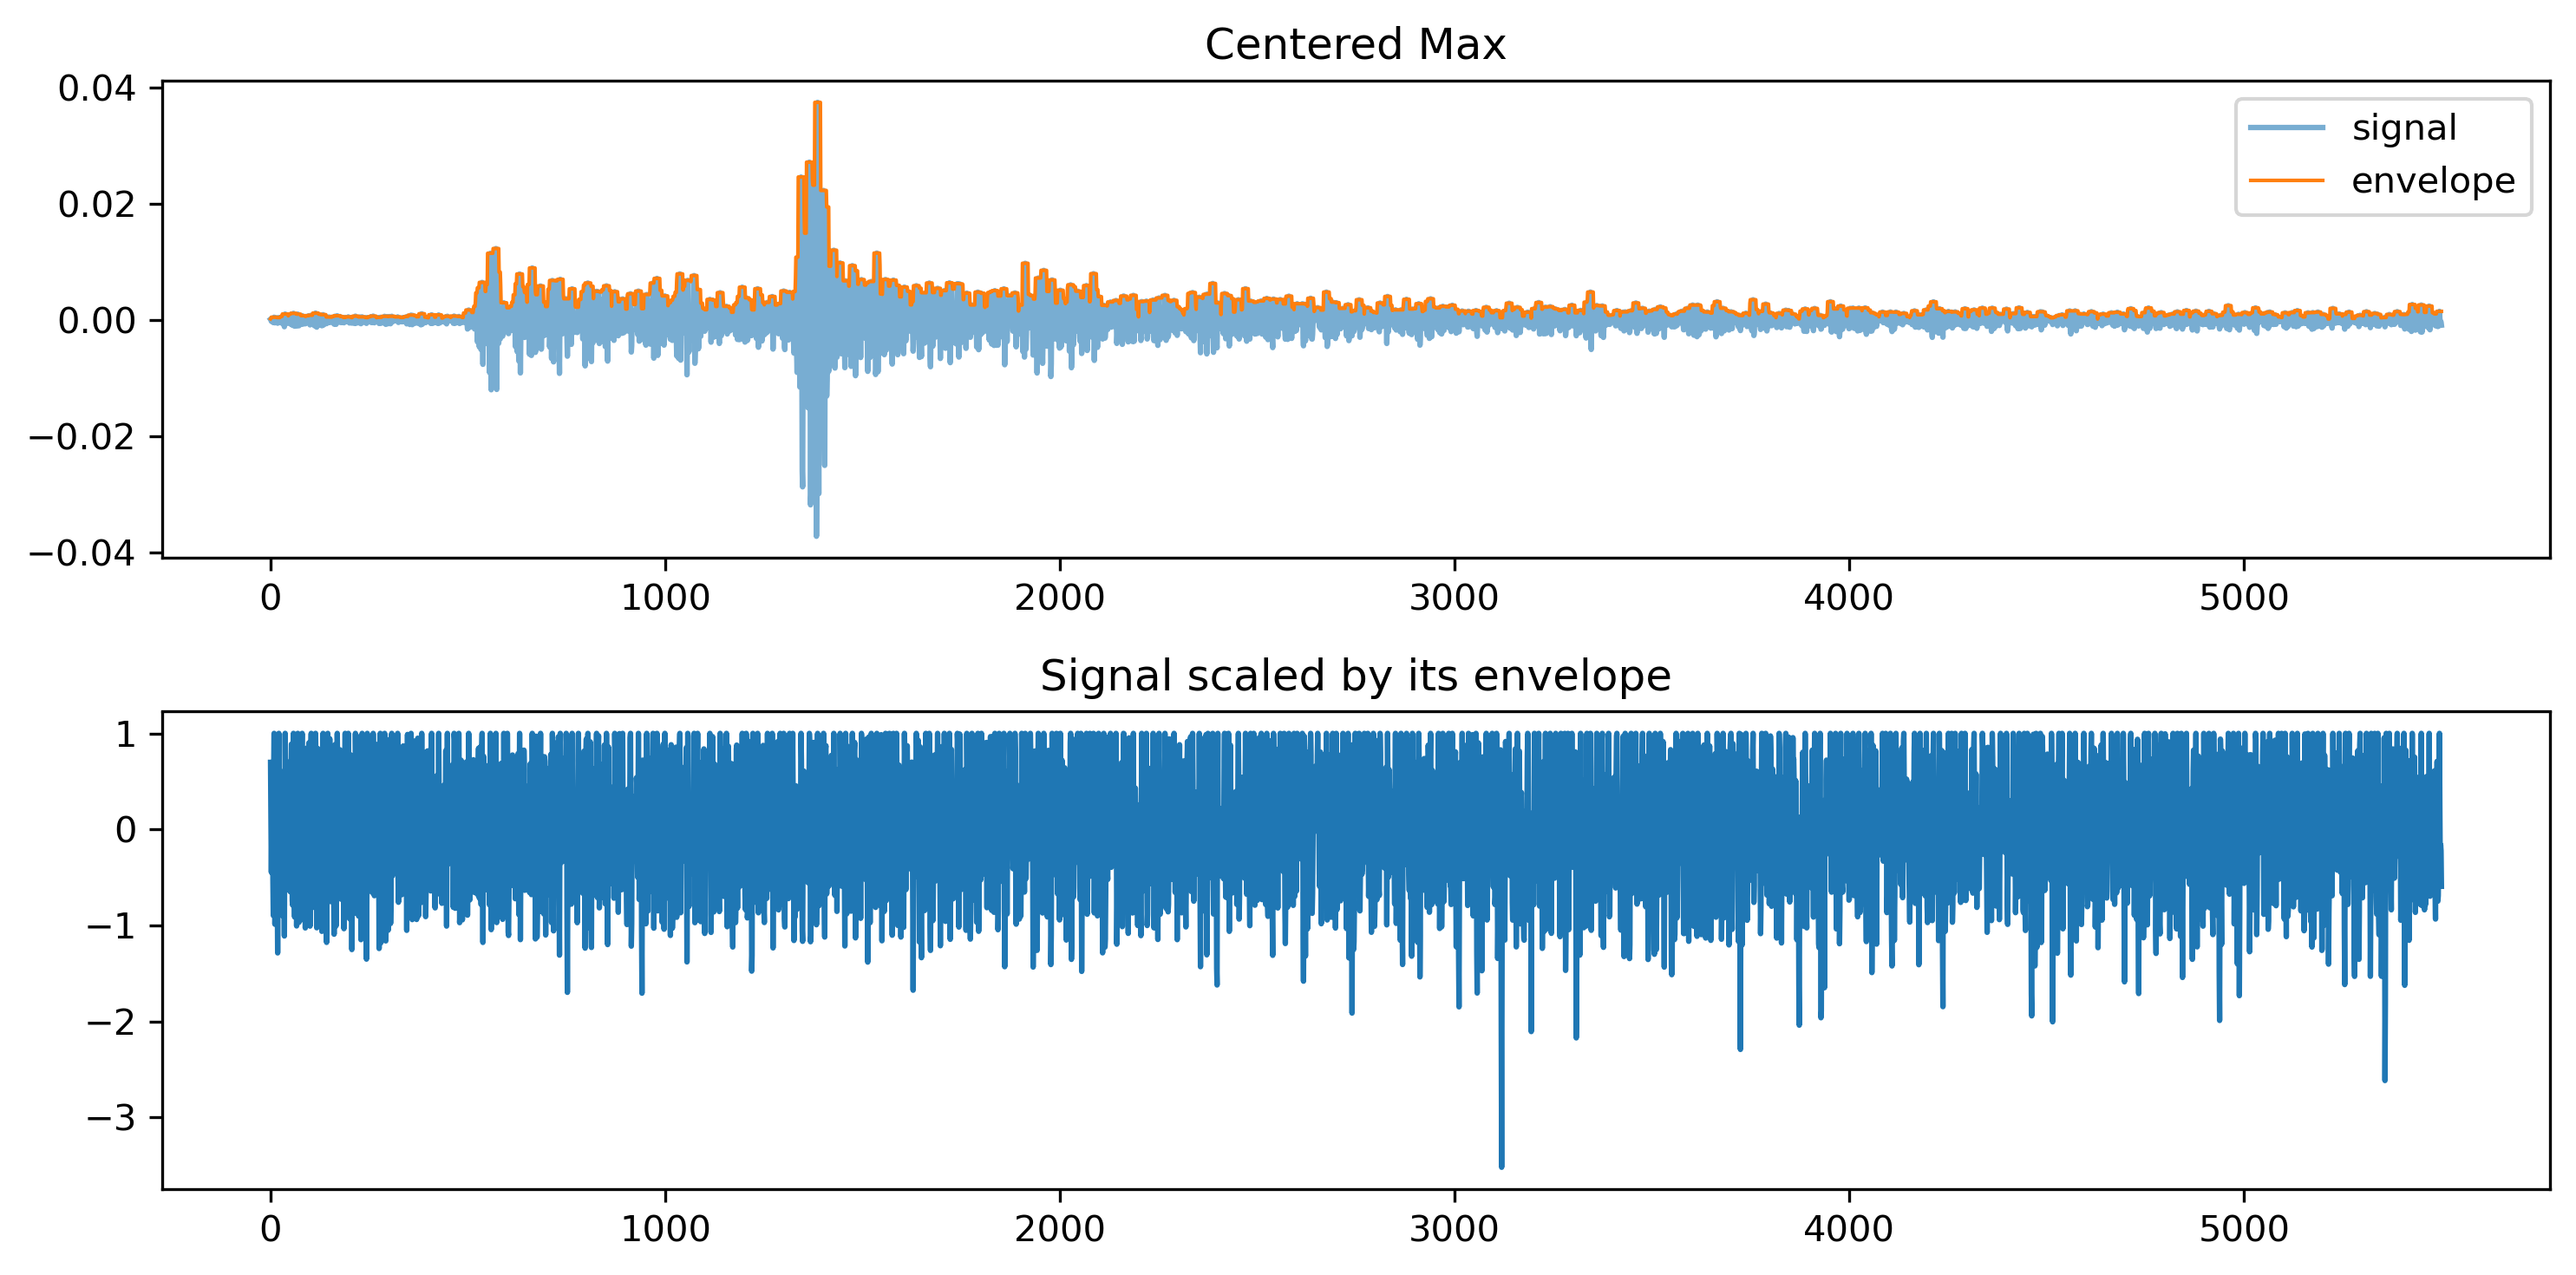

In [83]:
sample_idx = 9
waveform = np.nan_to_num(waveforms[0, :, sample_idx], nan=0)

plot_envelope(waveform, title='Centered Max', envelope_function=centered_max, window_len=15)

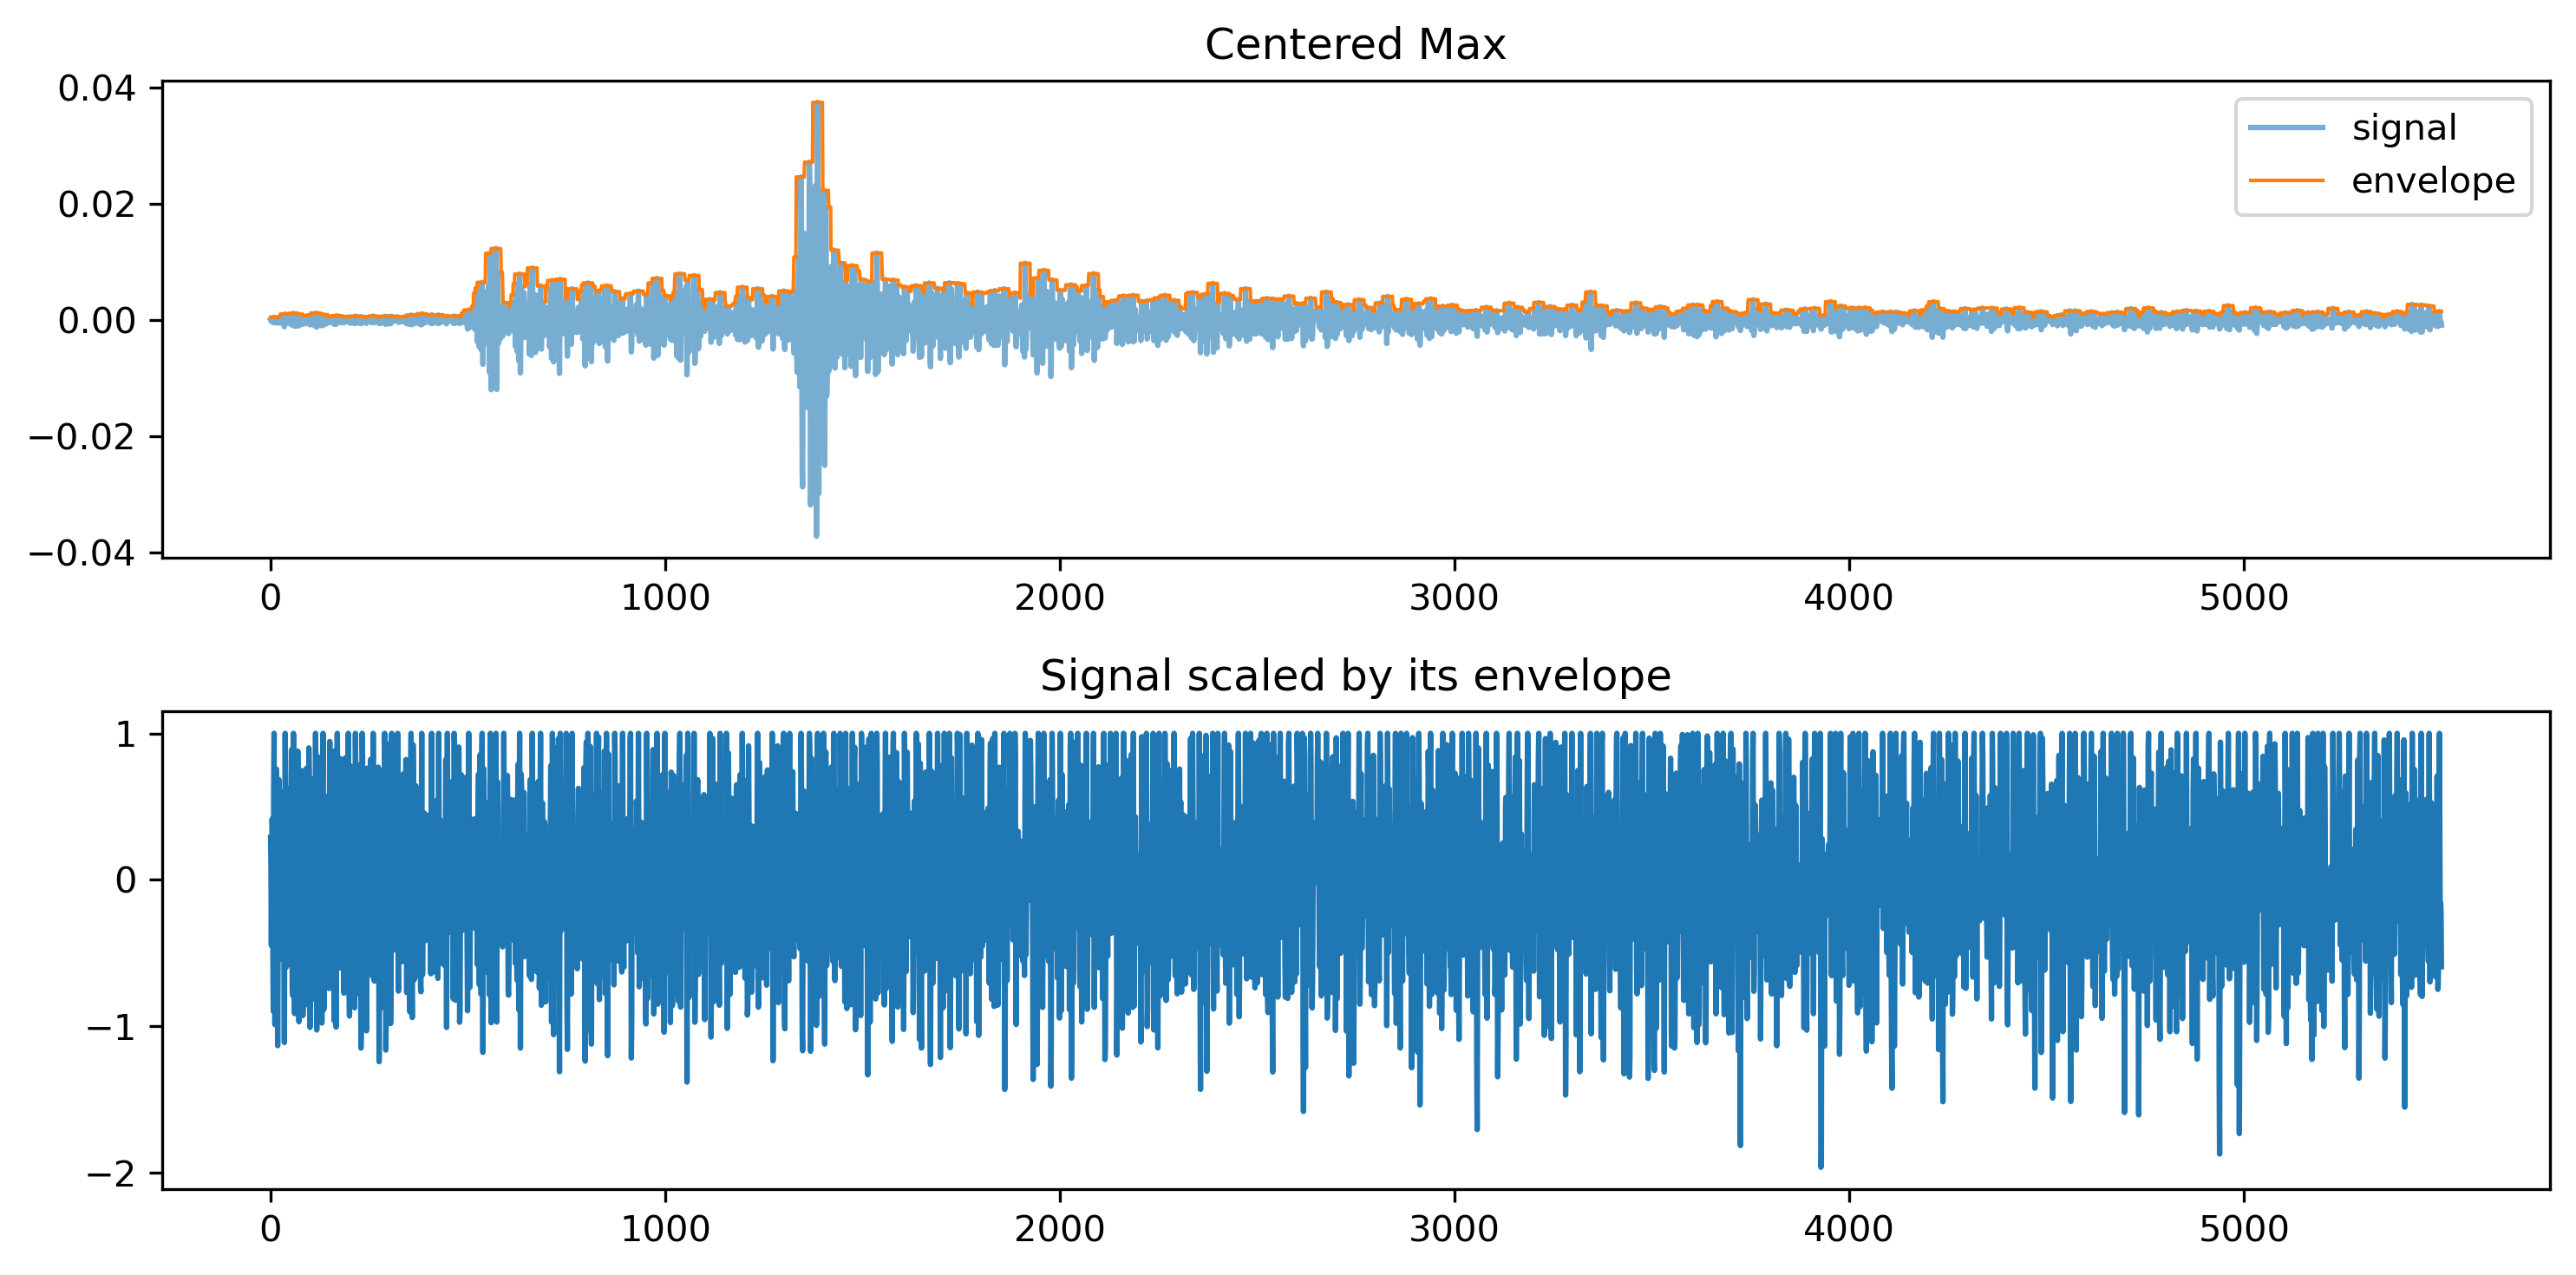

In [84]:
sample_idx = 9
waveform = np.nan_to_num(waveforms[0, :, sample_idx], nan=0)

plot_envelope(waveform, title='Centered Max', envelope_function=centered_max, window_len=25)

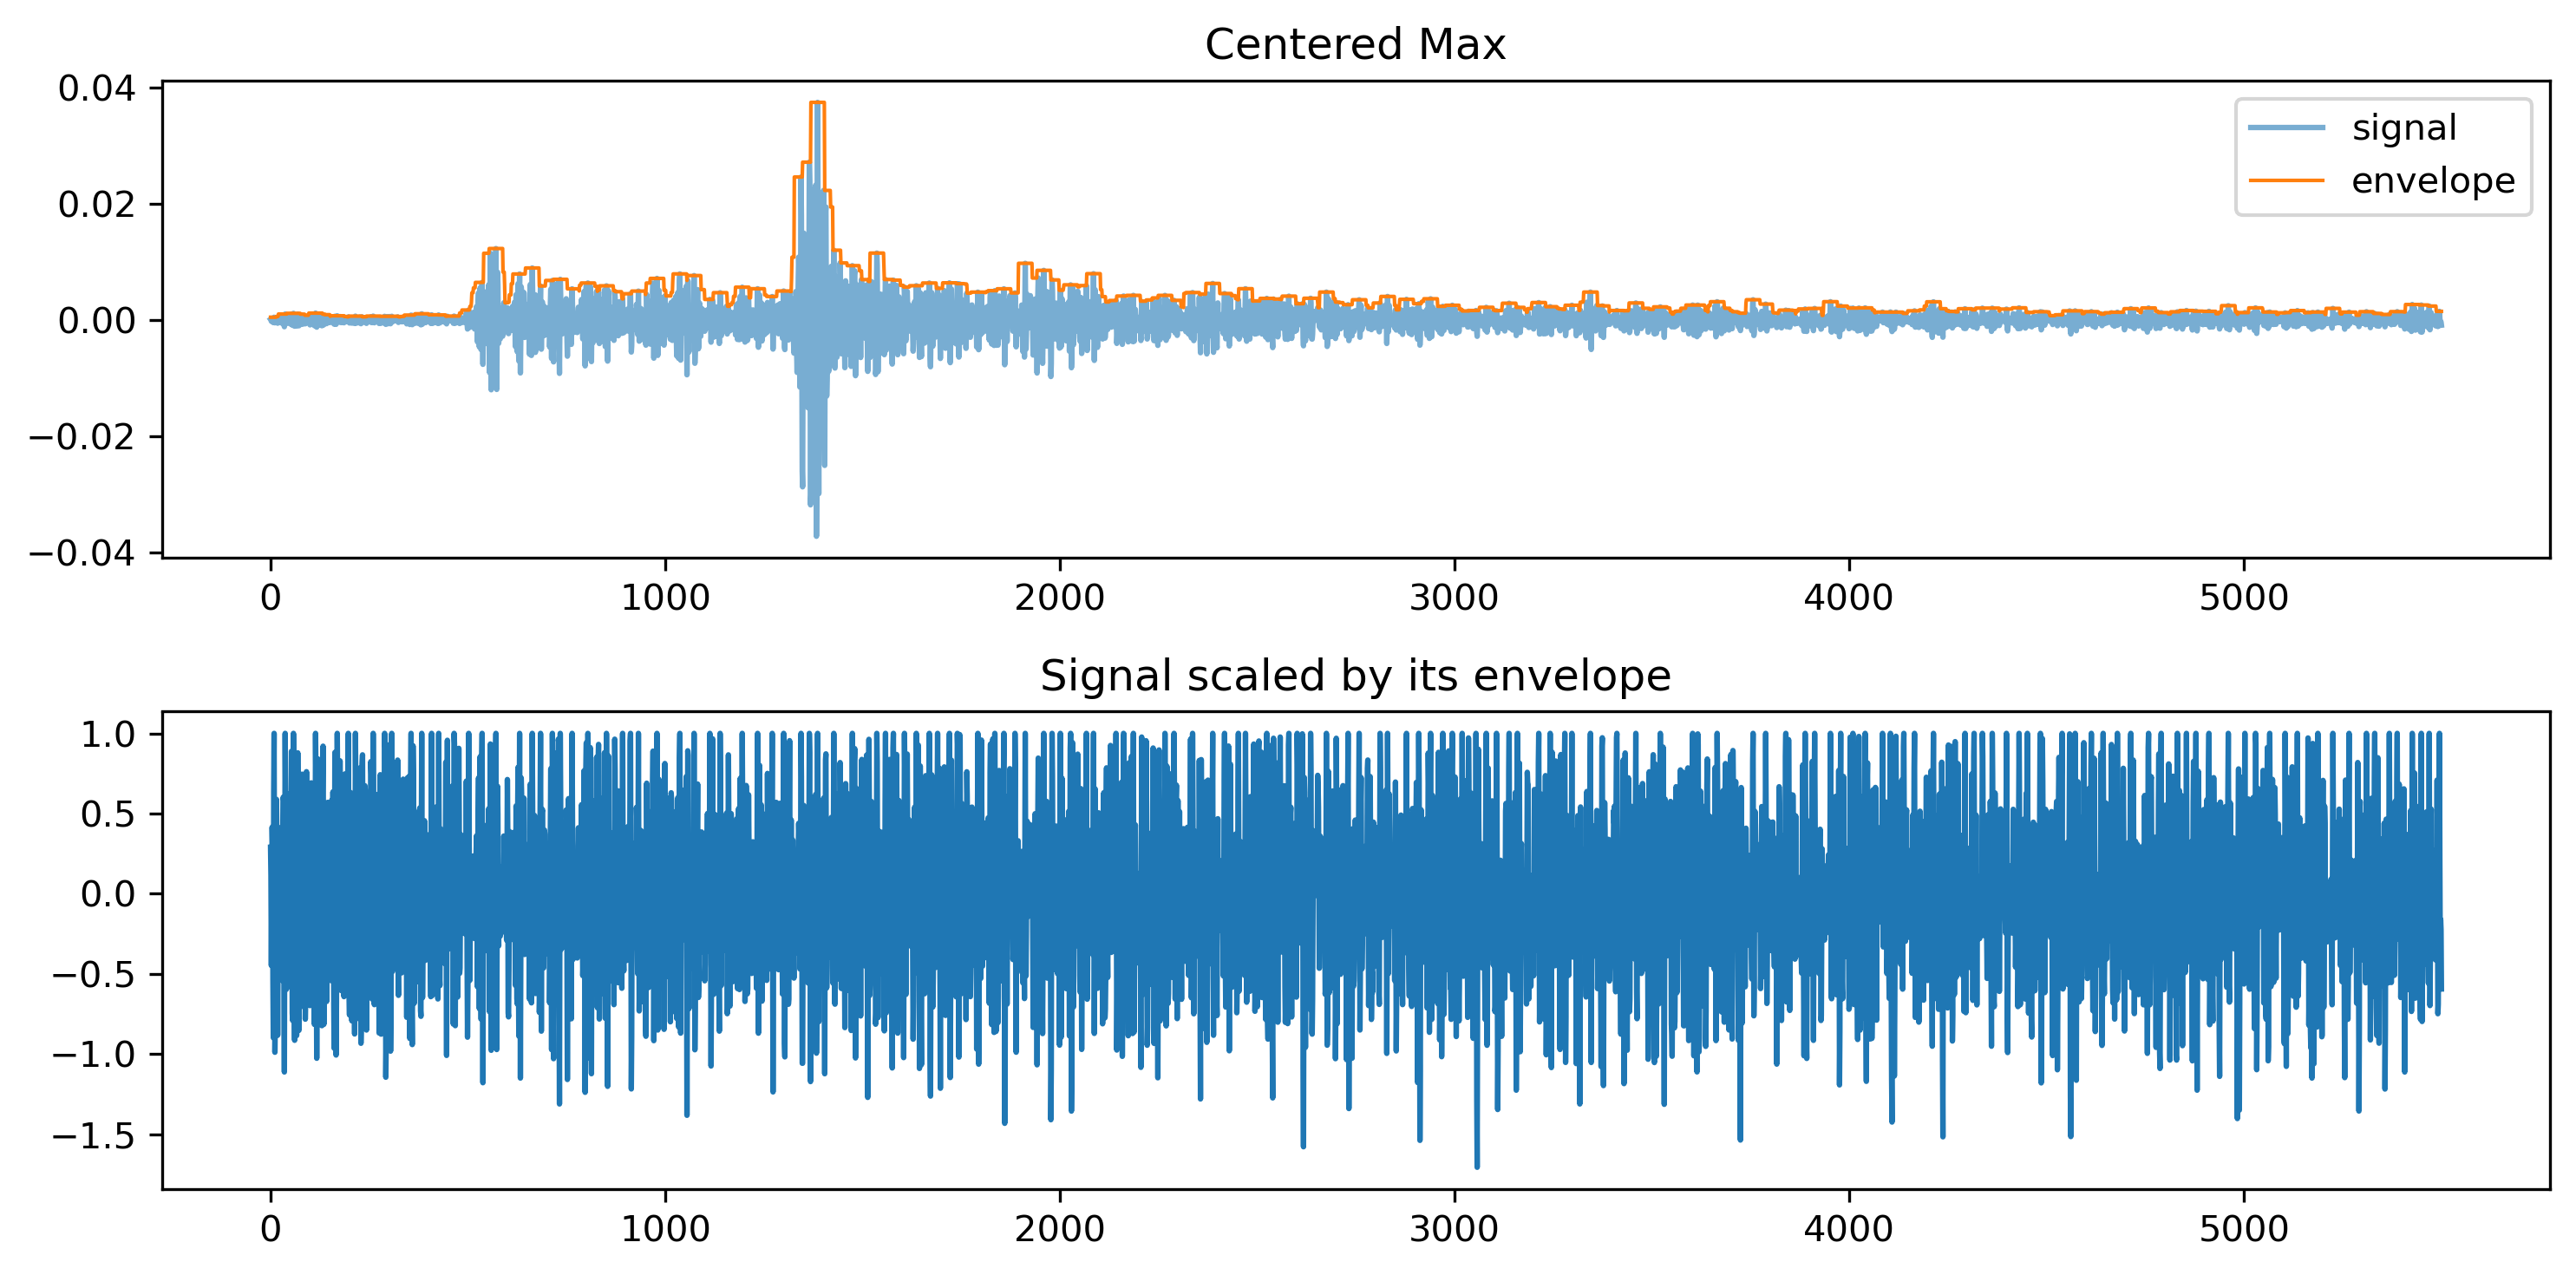

In [85]:
sample_idx = 9
waveform = np.nan_to_num(waveforms[0, :, sample_idx], nan=0)

plot_envelope(waveform, title='Centered Max', envelope_function=centered_max, window_len=35)

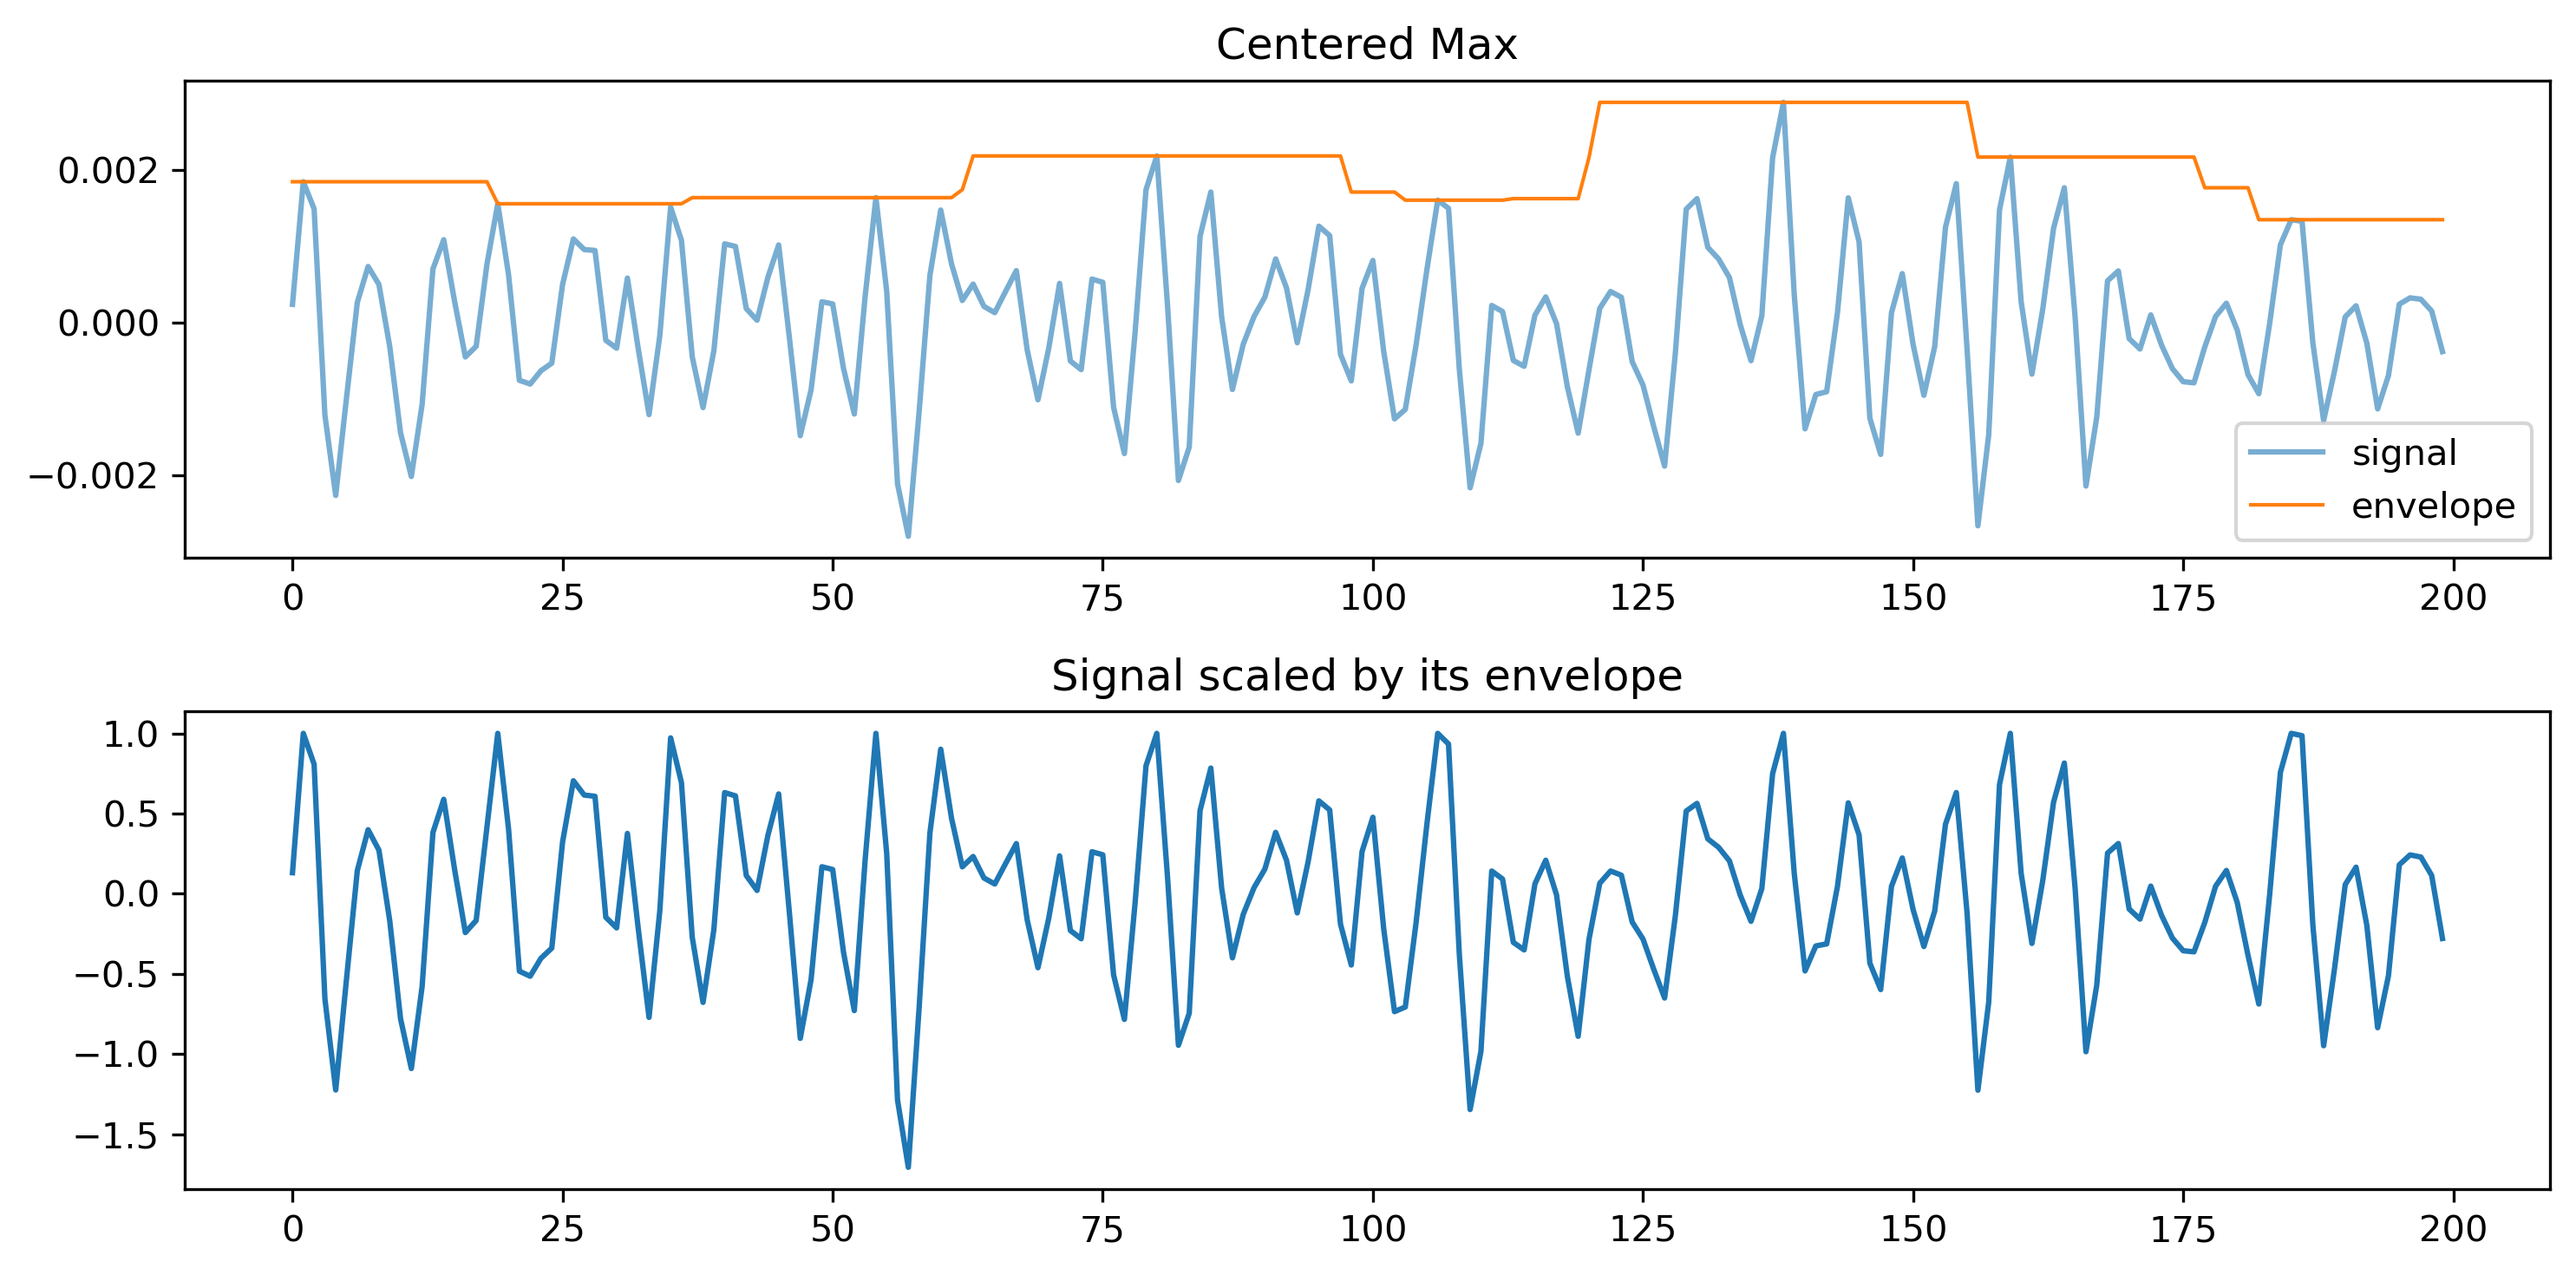

In [87]:
sample_idx = 9
waveform = np.nan_to_num(waveforms[0, 3000:3200, sample_idx], nan=0)

plot_envelope(waveform, title='Centered Max', envelope_function=centered_max, window_len=35)